# Bluecoats Phase 1: Project Evaluation - Supply Room and Stocking
### Supply room access events and staff interruptions
#### Questions: Is there a problem with supplies? What is the core issue? Can it be improved simply and quickly? Did it improve?
* Yes, there is a problem with keeping carts supplied. 
* Yes, it can be improved simply and quickly by hiring a new staff memeber to focus on this task.
* I just got the data, we will know how well it worked shortly =).


* Key Evaluation Targets:
    * Supplies + new role
        * Input data:
        * Output:
    * Breaks / lunch breaks
        * Input data:
        * Output:
    * Overall program
        * Input data: see below, graph paper notes, and spreadsheet notes
        * Output: before / after changes - demonstrate impact


* Exploration of strategies to evaluate the efficacy of the Bluecoats at both the **program-level** and the **project-evel** over a specific, uniform **interval of time**.
* The goal is to develope both:
    * **universal metrics**, applicable to all settings where bluecoats teams are deployed 
    * **custom project-, unit-, and/or entity-specific metrics** via *standardized processes/protocols* that allow for a common interpretation accross Bluecoats implementations
* Need to tighten some terminology here


* Ideas for *program* evaluation
    * retention:
    * engagement:
    * ops KPI's:
    * Self-report
* Start brainstorming *project* evaluation
    * universal metrics
    * universal vocabulary and interpretations
    * project categorization framework for maping vocabulary (metrics), creating a baseline metrics library for each project type, with flexibility to add additional custom metrics or metrics modules (collections of metrics)
    

* Things to categorize for label-mapping, process-mapping, "shortest path discovery", and other fine-grain analyses:
    * Metrics
    * Projects
    * Problems
    * Solutions
    * Governance
    * Management
    * Resources/supplies
    * Unit classifications beyond traditional "types" (Ex: ED Unit - high throughput, ED Unit - safety risk, ED Unit - high volatility, etc.)

In [1]:
# Modules
from bluecoats_p1_config import *

import pandas as pd
import numpy as np
from scipy import stats

import re
import copy
import math
import random
import datetime
from collections import defaultdict

import glob
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as col
from matplotlib import colormaps as colmap
import seaborn as sns; 
import plotly.graph_objects as go
import plotly.express as px

sns.set()
%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

# Program Parameters

## Constants

## Collections

In [3]:
# Dictionaries for labeling time
month_dict = dict({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec',})
day_name_dict = dict({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

hour_suffix = ['AM']*12 +['PM']*12
hour_vals_24 = [val for val in range(0,24)]
hour_vals_12 = [val%12+12 if val%12==0 else val%12 for val in range(0,24)]
hour_labels = [str(val)+suffix for val,suffix in zip(hour_vals_12,hour_suffix)]
hour_dict = dict(zip(hour_vals_24,hour_labels))

In [5]:
# Dictionaries for labeling rooms
idx_num_dict = {'477244':'1146','477245':'1135'}
num_idx_dict = {'1146':'477244','1135':'477245'}

In [7]:
# Custom colormaps
cdict_dark_blues = {
     'red': ((0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.3, 0.3),
              (1.0, 0.9, 0.9))}
dark_blues = col.LinearSegmentedColormap('my_blue_map', cdict_dark_blues, N=256, gamma=1)
colmap.register(name='blue', cmap=dark_blues)

cdict_dark_reds = {
     'red': ((0.0, 0.3, 0.3),
             (1.0, 0.9, 0.9)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))}
dark_reds = col.LinearSegmentedColormap('my_red_map', cdict_dark_reds, N=256, gamma=1)
colmap.register(name='red', cmap=dark_reds)

In [9]:
# Sankey/alluvial colors
color_dict = {'477244':RGB_BLUE,'477245':RGB_RED,'Apr':RGB_BLUE,'May':RGB_RED,
              'Weekday':RGB_BLUE,'Weekend':RGB_RED,'Day Shift':RGB_ORANGE,'Night Shift':RGB_BLUE}

# Class Definitions

# Function Definitions

## Data Cleaning

In [11]:
def clean_supply_data(supply_data):
        # Rename columns of interest and select subset
    col_dict = {supply_data.columns[0]:'card_holder',
                'SWH06 - Door Access Report (Admit or Reject)':'response',
                supply_data.columns[-1]:'timestamp',}
    supply_data = supply_data.rename(columns=col_dict)
    supply_data = supply_data[['card_holder','response','timestamp']]

    # Filter for relevant rows and reset index
    exclude_vals = ['Message Text','SWH06 - Door Access Report (Admit or Reject)']
    supply_data = supply_data[(supply_data['response'].notnull()) & 
                              (~supply_data['response'].isin(exclude_vals))]
    supply_data = supply_data.reset_index(drop=True)
    
    return supply_data

In [13]:
def get_event_records(supply_data):
    event_records = supply_data[['card_holder','timestamp']]
    event_records = event_records[event_records['card_holder'].notnull()]

    start_idx_list = event_records.index.to_list()
    stop_idx_list = start_idx_list[1:] + [len(supply_data)]
    event_idx_range = list(zip(start_idx_list,stop_idx_list))
    
    return event_records,event_idx_range

In [15]:
def get_response_records(supply_data, event_idx_range, curr_supply_room_id):
    response_data = supply_data['response'].str.strip()
    response_cols = ['status','scope','card_id','facility_id','supply_room_id','supply_room_name','entity_name']
    response_records_dict = {}

    for item in event_idx_range:
        start_idx=item[0]
        end_idx=item[1]
        response = ' '.join(response_data[start_idx:end_idx]).split(' \'')

        # Parse response
        status = response[0]
        scope = response[1].split(']\' ')[0].split('[')[-1]
        card_id = response[1].split(']\' ')[1].split()[1].split(')')[0]
        try:
            facility_id = response[1].split(']\' ')[1].split()[3].split(')')[0]
        except:
            print('No facility id provided!')
            facility_id = -999
        supply_room_id = curr_supply_room_id
        supply_room_name = response[2].split(' [')[0]
        entity_name = response[2].split(' [')[-1].split(']')[0]    

        response_records_dict[start_idx] = [status,scope,card_id,facility_id,supply_room_id,supply_room_name,entity_name]

    response_records = pd.DataFrame.from_dict(response_records_dict, orient='index', columns=response_cols)
    
    return response_records

In [17]:
def get_master_data(event_records_list,response_records_list,supply_records_list):
    # Events (unsorted)
    event_records_master = pd.concat(event_records_list)
    event_records_master = event_records_master.reset_index(drop=True)

    # Responses (unsorted)
    response_records_master = pd.concat(response_records_list)
    response_records_master = response_records_master.reset_index(drop=True)

    # Supply records (sorted by timestamp)
    supply_records_master = pd.concat(supply_records_list)
    supply_records_master['timestamp'] = pd.to_datetime(supply_records_master['timestamp'])
    supply_records_master = supply_records_master.sort_values('timestamp')
    supply_records_master = supply_records_master.reset_index(drop=True)
    # Add event_id col for unique reference
    event_id_col_loc = 0
    event_id_col_name = 'event_id'
    event_id_col_values = ['e'+str(idx).zfill(6) for idx in range(len(supply_records_master))]
    supply_records_master.insert(loc=event_id_col_loc, column=event_id_col_name, value=event_id_col_values)
    
    master_data_dict = {'event':event_records_master,
                        'response':response_records_master,
                        'supply':supply_records_master}
    
    return master_data_dict

In [19]:
def parse_supply_data(save=True):
    event_records_list = []
    response_records_list = []
    supply_records_list = []

    for file in glob.glob(RAW_SUPPLIES_PATH + 'supply_room_*.csv'):
        # Extract raw data
        file_name = file.split('/')[-1]
        curr_supply_room_id = file_name.split('_')[2]
        supply_data = pd.read_csv(RAW_SUPPLIES_PATH + file_name)

        # Clean supply data
        supply_data = clean_supply_data(supply_data)

        # Get event records
        event_records,event_idx_range = get_event_records(supply_data)
        event_records_list.append(event_records)

        # Get response records
        response_records = get_response_records(supply_data, event_idx_range, curr_supply_room_id)
        response_records_list.append(response_records)

        # Create supply records
        supply_records = event_records.merge(response_records, how='inner', left_index=True, right_index=True)
        supply_records_list.append(supply_records)

    # Get master data    
    master_data_dict = get_master_data(event_records_list,response_records_list,supply_records_list)

    if save:
        save_name = MASTER_SUPPLIES_PATH + 'supply_records_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
        master_data_dict['supply'].to_csv(save_name)

    return master_data_dict

## Data Visualization

In [21]:
def get_plot_data(plot_levels=[]):
    supply_groups = ['supply_room_id','year','month','day','hour','dayofweek','is_weekday','is_day_shift','is_top_10','is_supply_staff']
    supply_data = supply_records_master.groupby(supply_groups)[['event_id']].count()
    supply_data = supply_data.rename(columns={'event_id':'access_events'})

    if len(plot_levels)==0:
        plot_data = supply_data
    else:
        plot_levels = plot_levels
        plot_data = supply_data.groupby(axis=0, level=plot_levels).sum().reset_index()

    return plot_data

# Read Data

In [ ]:
master_data_dict = parse_supply_data(save=True)
event_records_master = master_data_dict['event']
response_records_master = master_data_dict['response']
supply_records_master = master_data_dict['supply']

## Event Records

In [ ]:
print(len(event_records_master))
print(len(event_records_master.columns))
event_records_master.head(2)

## Response Records

In [ ]:
print(len(response_records_master))
print(len(response_records_master.columns))
response_records_master.head(2)

## Supply Records

In [18]:
# Time Cols
supply_records_master['year'] = supply_records_master['timestamp'].dt.year
supply_records_master['month'] = supply_records_master['timestamp'].dt.month
supply_records_master['day'] = supply_records_master['timestamp'].dt.day
supply_records_master['hour'] = supply_records_master['timestamp'].dt.hour
supply_records_master['dayofweek'] = supply_records_master['timestamp'].dt.dayofweek
supply_records_master['dayofyear'] = supply_records_master['timestamp'].dt.dayofyear
supply_records_master['year_month'] = supply_records_master['timestamp'].values.astype('datetime64[M]')
supply_records_master['year_month_week'] = supply_records_master['timestamp'].values.astype('datetime64[W]')
supply_records_master['year_month_day'] = supply_records_master['timestamp'].values.astype('datetime64[D]')

# Indicator Cols
supply_records_master['is_weekday'] = supply_records_master['dayofweek'].apply(lambda x: 1 if x<5 else 0)
supply_records_master['is_day_shift'] = supply_records_master['hour'].apply(lambda x: 1 if x>6 and x<19 else 0)
count_top_10 = len(supply_records_master['card_id'].unique())//10
is_top_10 = dict(supply_records_master['card_id'].value_counts().head(count_top_10))
supply_records_master['is_top_10'] = supply_records_master['card_holder'].apply(lambda x: 1 if x in is_top_10.keys() else 0)
supply_records_master['is_supply_staff'] = supply_records_master['card_id'].apply(lambda x: 1 if x==SUPPLY_STAFF_ID else 0)

In [ ]:
print(len(supply_records_master))
print(len(supply_records_master.columns))
supply_records_master.head(2)

In [20]:
idx_slice = pd.IndexSlice

In [ ]:
################################################################

In [21]:
################ TEMP ANALYSIS START 2023/08/04 ################

In [ ]:
################################################################

In [ ]:
supply_records_master.head(2)

In [23]:
print('Total access events (Room ID 477244 - Room # 1146):',len(supply_records_master[supply_records_master['supply_room_id']=='477244']))
print('Total access events (Room ID 477245 - Room # 1135):',len(supply_records_master[supply_records_master['supply_room_id']=='477245']))

Total access events (Room ID 477244 - Room # 1146): 7214
Total access events (Room ID 477245 - Room # 1135): 13839


In [24]:
# Column multiIndex definition
room_num = np.repeat(['1146','1135'],2)
room_idx = np.repeat(['477244','477245'],2)
months = ['April','June']*2
col_levels = [(num,idx,mon) for num,idx,mon in zip(room_num,room_idx,months)]
col_index = pd.MultiIndex.from_tuples(col_levels,names=['Room Number', 'Room ID', 'Month'])

# Room 477244
temp4_477244 = pd.DataFrame(supply_records_master[(supply_records_master['supply_room_id']=='477244') & 
                                           (supply_records_master['month']==4)].day.value_counts().sort_index())
temp6_477244 = pd.DataFrame(supply_records_master[(supply_records_master['supply_room_id']=='477244') & 
                                           (supply_records_master['month']==6)].day.value_counts().sort_index())
# Room 477245
temp4_477245 = pd.DataFrame(supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                           (supply_records_master['month']==4)].day.value_counts().sort_index())
temp6_477245 = pd.DataFrame(supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                           (supply_records_master['month']==6)].day.value_counts().sort_index())
# concat and send to ken/brenna
temp_477244 = temp4_477244.merge(temp6_477244, how='outer', left_index=True, right_index=True)
temp_477245 = temp4_477245.merge(temp6_477245, how='outer', left_index=True, right_index=True)

# Merge and rename indices
access_events_room_dayofmonth = temp_477244.merge(temp_477245, how='outer', left_index=True, right_index=True)
access_events_room_dayofmonth.columns = col_index
access_events_room_dayofmonth.index.name = 'Day of Month'

In [25]:
save_name_csv = MASTER_SUPPLIES_PATH + 'access_events_room_dayofmonth_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
access_events_room_dayofmonth.to_csv(save_name_csv)

In [26]:
save_name_xlsx = MASTER_SUPPLIES_PATH + 'access_events_room_dayofmonth_' + str(datetime.datetime.now().date()).replace('-','') + '.xlsx'
sheet_name = 'Access Events - Room,Month,Day'
access_events_room_dayofmonth.to_excel(save_name_xlsx, sheet_name=sheet_name)

In [27]:
access_events_room_dayofmonth.head()

Room Number    1146        1135     
Room ID      477244      477245     
Month         April June  April June
Day of Month                        
1               109   14    168  213
2               113   10    141  184
3               150    1    187  124
4               167    4    228  151
5               162   16    204  203

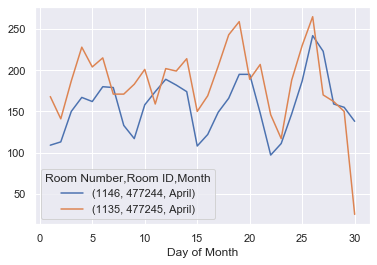

In [28]:
access_events_room_dayofmonth.loc[:,[('1146','477244','April'),('1135','477245','April')]].plot()

In [29]:
access_events_room_dayofmonth.columns

MultiIndex([('1146', '477244', 'April'),
            ('1146', '477244',  'June'),
            ('1135', '477245', 'April'),
            ('1135', '477245',  'June')],
           names=['Room Number', 'Room ID', 'Month'])

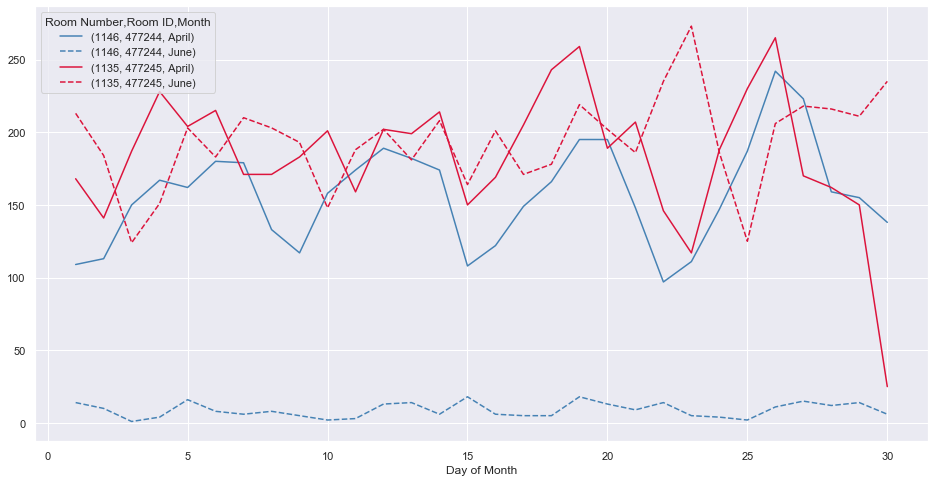

In [31]:
ax1 = access_events_room_dayofmonth.loc[:,idx_slice[:,'477244',:]].plot(figsize=(16,8),color='steelblue',style=['-','--'])
ax2 = access_events_room_dayofmonth.loc[:,idx_slice[:,'477245',:]].plot(ax=ax1,figsize=(16,8), color='crimson',style=['-','--'])

In [ ]:
################################################################

In [ ]:
################ TEMP ANALYSIS END 2023/08/04 ################

In [ ]:
################################################################

# Analysis

In [ ]:
################################################################

In [32]:
################ TEMP ANALYSIS START 2023/08/17 ################

In [ ]:
################################################################

In [ ]:
supply_records_master.head(2)

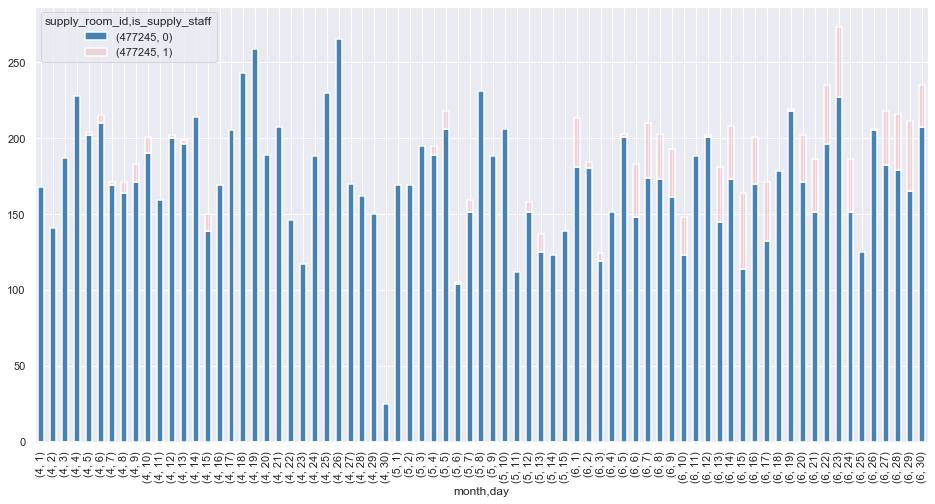

In [204]:
plot_data = supply_records_master.groupby(['month','day','is_supply_staff','supply_room_id']).count()[['event_id']].unstack().droplevel(axis=1, level=0)[['477245']].unstack().fillna(0)
plot_data.plot(figsize=(16,8), kind='bar', stacked=True, color=['steelblue',(1,0,0,0.1)], edgecolor='white', linewidth=1.5)

In [231]:
[plot_data.loc[4].sum(axis=1).mean()] + plot_data.loc[4].mean().to_list() + [plot_data.loc[4].sum(axis=1).median()] + plot_data.loc[4].median().to_list() + [plot_data.loc[4].sum(axis=1).std()] + plot_data.loc[4].std().to_list()

[183.93333333333334,
 182.1,
 1.8333333333333333,
 187.5,
 187.5,
 0.0,
 45.99020385445918,
 46.15965546993878,
 3.620662287800236]

In [233]:
[plot_data.loc[5].sum(axis=1).mean()] + plot_data.loc[5].mean().to_list() + [plot_data.loc[5].sum(axis=1).median()] + plot_data.loc[5].median().to_list() + [plot_data.loc[5].sum(axis=1).std()] + plot_data.loc[5].std().to_list()

[166.93333333333334,
 163.86666666666667,
 3.066666666666667,
 169.0,
 169.0,
 0.0,
 38.6087826179238,
 38.4500913368164,
 4.605379876787994]

In [232]:
[plot_data.loc[6].sum(axis=1).mean()] + plot_data.loc[6].mean().to_list() + [plot_data.loc[6].sum(axis=1).median()] + plot_data.loc[6].median().to_list() + [plot_data.loc[6].sum(axis=1).std()] + plot_data.loc[6].std().to_list()

[193.9,
 169.63333333333333,
 24.266666666666666,
 201.5,
 173.0,
 31.5,
 31.47998816982646,
 29.55005494286663,
 17.2125321893037]

In [505]:
plot_levels = ['year','month','day','dayofweek','is_supply_staff','is_weekday','is_day_shift','supply_room_id']
plot_data = get_plot_data(plot_levels)
plot_data = plot_data[plot_data['supply_room_id']=='477245']
plot_data.tail()

,year,month,day,dayofweek,is_supply_staff,is_weekday,is_day_shift,supply_room_id,access_events
338,2023,6,29,3,0,1,1,477245,99
339,2023,6,29,3,1,1,0,477245,46
341,2023,6,30,4,0,1,0,477245,85
343,2023,6,30,4,0,1,1,477245,122
344,2023,6,30,4,1,1,0,477245,28


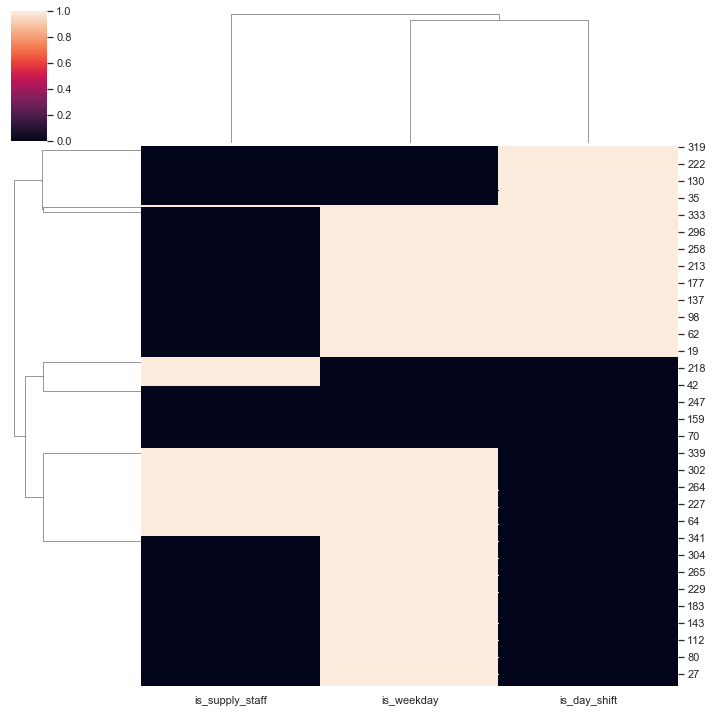

In [259]:
sns.clustermap(plot_data[['is_weekday','is_day_shift','is_supply_staff']])

In [262]:
plot_data.groupby(['is_weekday','is_day_shift','is_supply_staff']).sum()

year  month  day  dayofweek  \
is_weekday is_day_shift is_supply_staff                                  
0          0            0                 44506    108  307        121   
                        1                 20230     51  112         52   
           1            0                 42483    104  277        115   
1          0            0                107219    267  743        107   
                        1                 62713    171  427         72   
           1            0                107219    267  743        107   
                        1                  2023      5    5          4   

                                         access_events  
is_weekday is_day_shift is_supply_staff                 
0          0            0                         1454  
                        1                          155  
           1            0                         1606  
1          0            0                         4272  
                        1                          673  
           1            0                         5678  
                        1                            1

In [27]:
# NOTE 1 - 2023/08/17
# ~2% of all trips, but that doesnt capture full impact - other staff trips could be faster/smaller now
# look at time between access events, and changes in time btw. events from april to june

# Test for equal mean/variance of staff access events (i.e. april vs (june-vaughn))
# modeling/forecasting access events using existing variables

In [ ]:
# NOTE 2 - 2023/08/17: The work below this cell is older and based on card id

In [181]:
# April (pre new position), supply room 477245
temp0 = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                              (supply_records_master['month']==4)]['card_id']
card_id_events_april = pd.concat([temp0.value_counts(0),temp0.value_counts(1)],axis=1)
card_id_events_april.columns = ['events','pct']
card_id_events_april['pct'] = card_id_events_april['pct'].round(3)*100

print('APRIL\n')
print('Pct access events by top user:\n',(1 - card_id_events_april.iloc[1:,0].sum()/card_id_events_april['events'].sum())*100)
print()
print('Top 10% access events:\n',card_id_events_april.head(count_top_10).sum())
print()
print('Top 10% access events stats:\n',card_id_events_april.head(count_top_10).describe())

card_id_events_april.head(count_top_10)

APRIL

Pct access events by top user:
 2.1928234867705676

Top 10% access events:
 events    3517.0
pct         64.3
dtype: float64

Top 10% access events stats:
          events      pct
count   76.0000  76.0000
mean    46.2763   0.8461
std     18.4547   0.3412
min     26.0000   0.5000
25%     32.0000   0.6000
50%     41.0000   0.7000
75%     56.5000   1.0250
max    121.0000   2.2000


,events,pct
220468,121,2.2
183363,82,1.5
220896,82,1.5
220017,81,1.5
241962,80,1.4
243673,77,1.4
220216,76,1.4
220867,73,1.3
243025,71,1.3
108264,70,1.3


In [182]:
# June (post new position), supply room 477245
temp1 = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                              (supply_records_master['month']==6)]['card_id']
card_id_events_june = pd.concat([temp1.value_counts(0),temp1.value_counts(1)],axis=1)
card_id_events_june.columns = ['events','pct']
card_id_events_june['pct'] = card_id_events_june['pct'].round(3)*100

print('JUNE\n')
print('Pct access events by top user:\n',(1 - card_id_events_june.iloc[1:,0].sum()/card_id_events_june['events'].sum())*100)
print()
print('Top 10% access events:',card_id_events_june.head(count_top_10).sum())
print()
print('Top 10% access events stats:\n',card_id_events_june.head(count_top_10).describe())

card_id_events_june.head(count_top_10)

JUNE

Pct access events by top user:
 12.515042117930209

Top 10% access events: events    3886.0
pct         66.8
dtype: float64

Top 10% access events stats:
          events      pct
count   76.0000  76.0000
mean    51.1316   0.8789
std     80.8421   1.3887
min     23.0000   0.4000
25%     30.0000   0.5000
50%     36.0000   0.6000
75%     49.2500   0.8250
max    728.0000  12.5000


,events,pct
159215,728,12.5
108264,104,1.8
243673,101,1.7
220468,85,1.5
157760,83,1.4
243025,78,1.3
251964,76,1.3
243492,76,1.3
214588,73,1.3
220470,72,1.2


In [36]:
# Access event mean without vaughn
print(card_id_events_april.events.mean())
print(card_id_events_june.iloc[1:].events.mean())

12.892523364485982
12.8510101010101


In [37]:
# Access events median without vaughn
print(card_id_events_april.events.median())
print(card_id_events_june.iloc[1:].events.median())

5.0
5.0


In [38]:
# Access events std dev without vaughn
print(card_id_events_april.events.std())
print(card_id_events_june.iloc[1:].events.std())

18.17215720818479
17.171672993843522


In [39]:
# Vaughn (card_id 159215) access events by month, room idx 477245
supply_vaughn = supply_records_master[(supply_records_master['card_id']=='159215')].groupby(['month','dayofweek'])[['event_id']].count().unstack(level=0).fillna(0).droplevel(axis=1,level=0)
supply_vaughn.index = supply_vaughn.index.map(day_name_dict)
supply_vaughn.columns = supply_vaughn.columns.map(month_dict)
supply_vaughn

month,Apr,May,Jun
dayofweek,,,
Mon,12.0,1.0,5.0
Tues,0.0,0.0,138.0
Wed,6.0,0.0,143.0
Thurs,10.0,6.0,197.0
Fri,4.0,22.0,141.0
Sat,24.0,17.0,104.0
Sun,12.0,9.0,0.0


In [40]:
# All access events by month, room idx 477245
supply_477245 = supply_records_master[(supply_records_master['supply_room_id']=='477245')].groupby(['month','dayofweek'])[['event_id']].count().unstack(level=0).fillna(0).droplevel(axis=1,level=0)
supply_477245.index = supply_477245.index.map(day_name_dict)
supply_477245.columns = supply_477245.columns.map(month_dict)
supply_477245

month,Apr,May,Jun
dayofweek,,,
Mon,781,539,830
Tues,860,357,784
Wed,930,401,820
Thurs,773,307,1026
Fri,754,376,1086
Sat,785,242,629
Sun,635,282,642


In [41]:
supply_477245.sum()

month
Apr    5518
May    2504
Jun    5817
dtype: int64

In [42]:
vaughn_impact = supply_477245.Apr.sum() - (supply_477245.Jun.sum() - supply_vaughn.Jun.sum())
print('Supply Room 1135 - ID 477245:')
print('Monthly events reduced by Vaughn:',vaughn_impact)
print('Monthly hours saved by Vaughn (2 minute trip time):', (2*vaughn_impact)/60)

Supply Room 1135 - ID 477245:
Monthly events reduced by Vaughn: 429.0
Monthly hours saved by Vaughn (2 minute trip time): 14.3


In [ ]:
################################################################

In [43]:
################ TEMP ANALYSIS END 2023/08/17 ################

In [ ]:
################################################################

## Day of Week

Text(0, 0.5, 'Access Events')

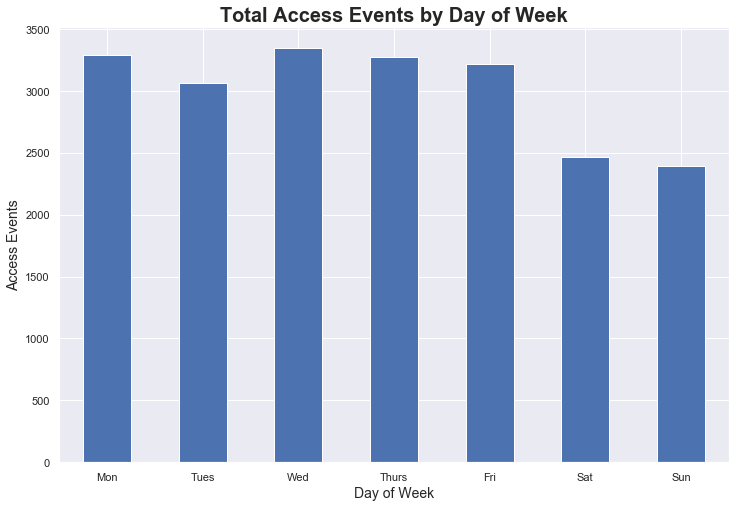

In [44]:
ax = supply_records_master.groupby(['dayofweek']).count()['event_id'].plot(figsize=(12,8),kind='bar')
xlabels = [day_name_dict[int(item.get_text())] for item in ax.get_xticklabels()]

ax.set_title('Total Access Events by Day of Week', fontsize=20, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_xticklabels(xlabels, rotation=0)
ax.set_ylabel('Access Events', fontsize=14)

In [45]:
plot_levels = ['year','month','day','dayofweek']
plot_data = get_plot_data(plot_levels)
plot_data.head()

,year,month,day,dayofweek,access_events
0,2023,4,1,5,277
1,2023,4,2,6,254
2,2023,4,3,0,337
3,2023,4,4,1,395
4,2023,4,5,2,366


Text(0, 0.5, 'Access Events')

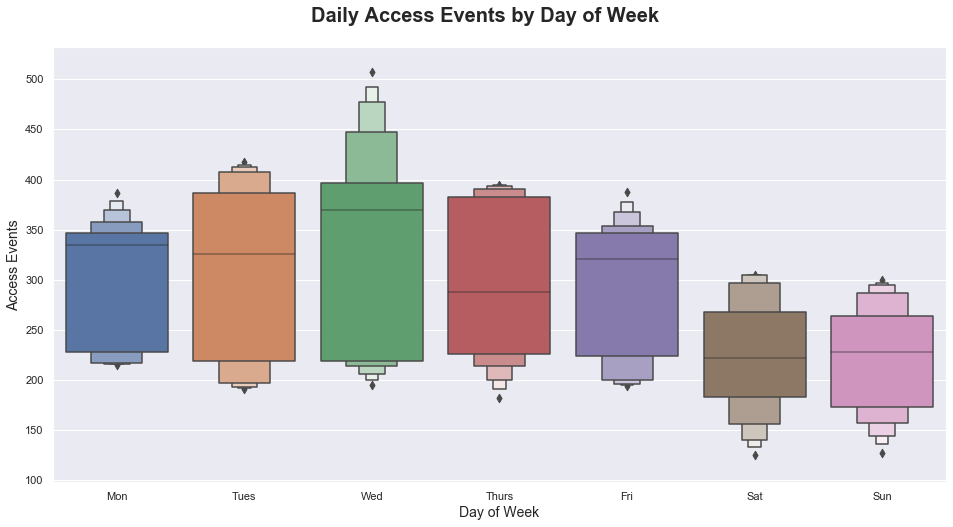

In [46]:
a = sns.boxenplot(data=plot_data, x='dayofweek', y='access_events', k_depth='full')
xlabels = [day_name_dict[int(item.get_text())] for item in a.get_xticklabels()]

a.figure.set_size_inches(16,8)
a.figure.suptitle('Daily Access Events by Day of Week', fontsize=20, weight='bold', y=0.95)
a.set_xlabel('Day of Week', fontsize=14)
a.set_xticklabels(xlabels)
a.set_ylabel('Access Events', fontsize=14)

Text(0, 0.5, 'Access Events')

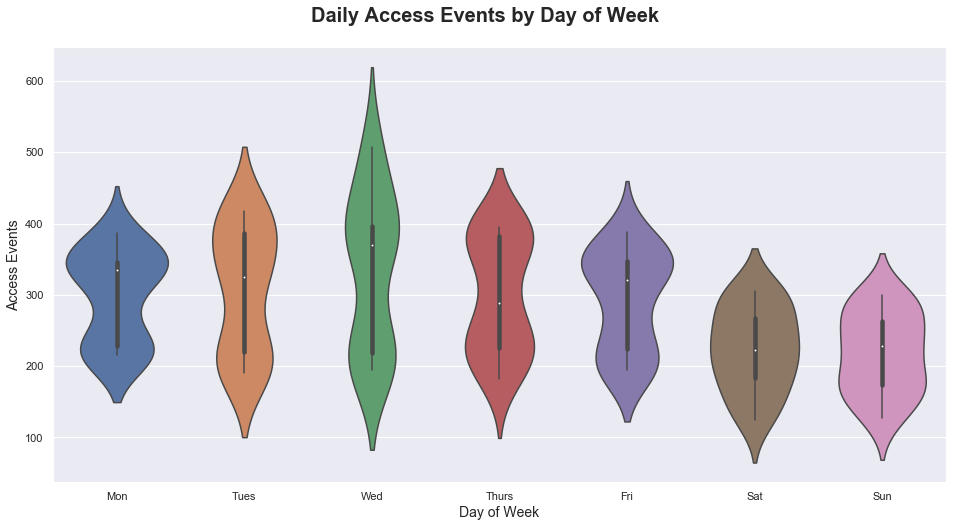

In [47]:
a = sns.violinplot(data=plot_data, x='dayofweek', y='access_events', bw=0.5)
xlabels = [day_name_dict[int(item.get_text())] for item in a.get_xticklabels()]

a.figure.set_size_inches(16,8)
a.figure.suptitle('Daily Access Events by Day of Week', fontsize=20, weight='bold', y=0.95)
a.set_xlabel('Day of Week', fontsize=14)
a.set_xticklabels(xlabels)
a.set_ylabel('Access Events', fontsize=14)

Text(20.799999999999997, 0.5, 'Access Events')

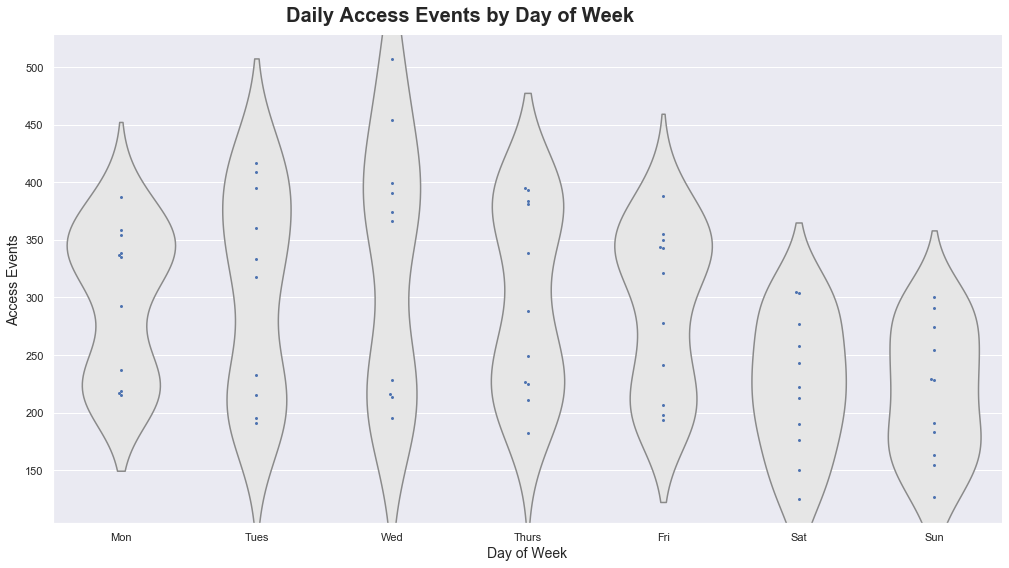

In [48]:
a = sns.catplot(data=plot_data, x="dayofweek", y="access_events", kind="violin", color=".9", inner=None, bw=0.5)
b = sns.swarmplot(data=plot_data, x="dayofweek", y="access_events", size=3)
xlabels = [day_name_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Day of Week', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

In [49]:
plot_levels = ['year','month','day','dayofweek','is_day_shift']
plot_data = get_plot_data(plot_levels)
plot_data.head()

,year,month,day,dayofweek,is_day_shift,access_events
0,2023,4,1,5,0,108
1,2023,4,1,5,1,169
2,2023,4,2,6,0,119
3,2023,4,2,6,1,135
4,2023,4,3,0,0,163


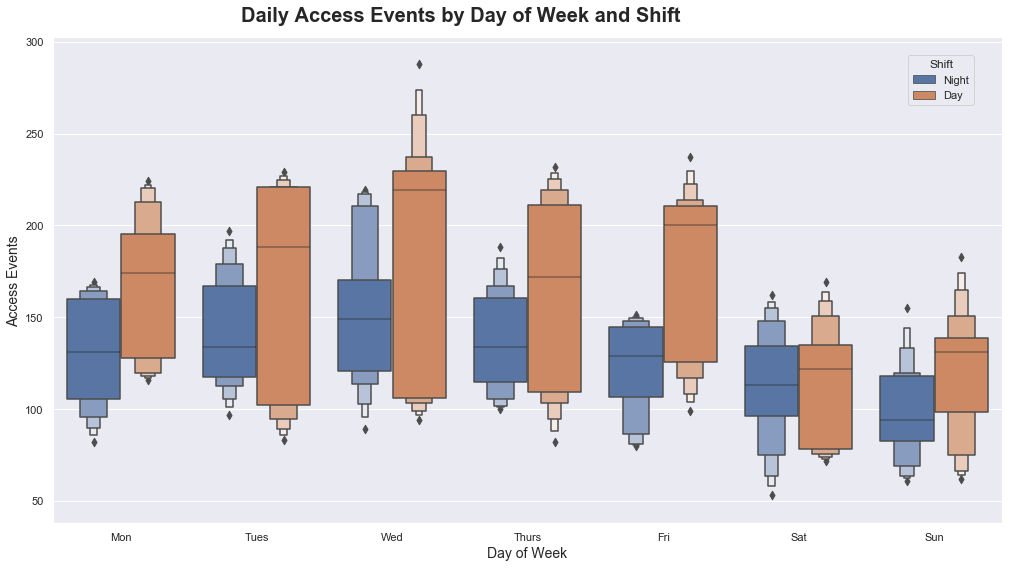

In [50]:
a = sns.catplot(data=plot_data, x='dayofweek', y='access_events',hue='is_day_shift', kind='boxen', k_depth='full', legend_out=False)
xlabels = [day_name_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week and Shift', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Day of Week', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Night','Day']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Shift')

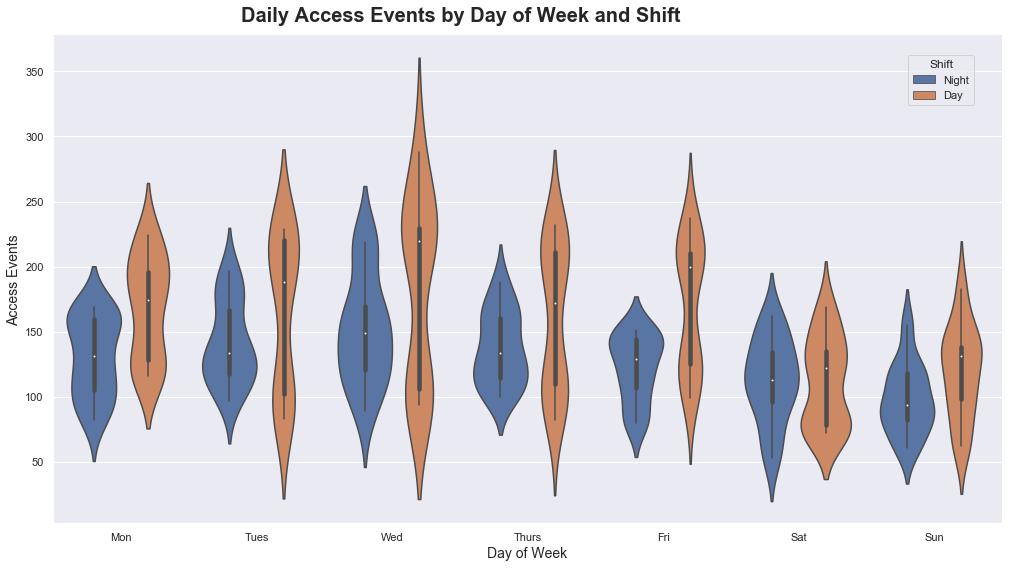

In [51]:
a = sns.catplot(data=plot_data, x='dayofweek', y='access_events',hue='is_day_shift', kind='violin', bw=0.5, legend_out=False)
xlabels = [day_name_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week and Shift', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Day of Week', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Night','Day']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Shift')

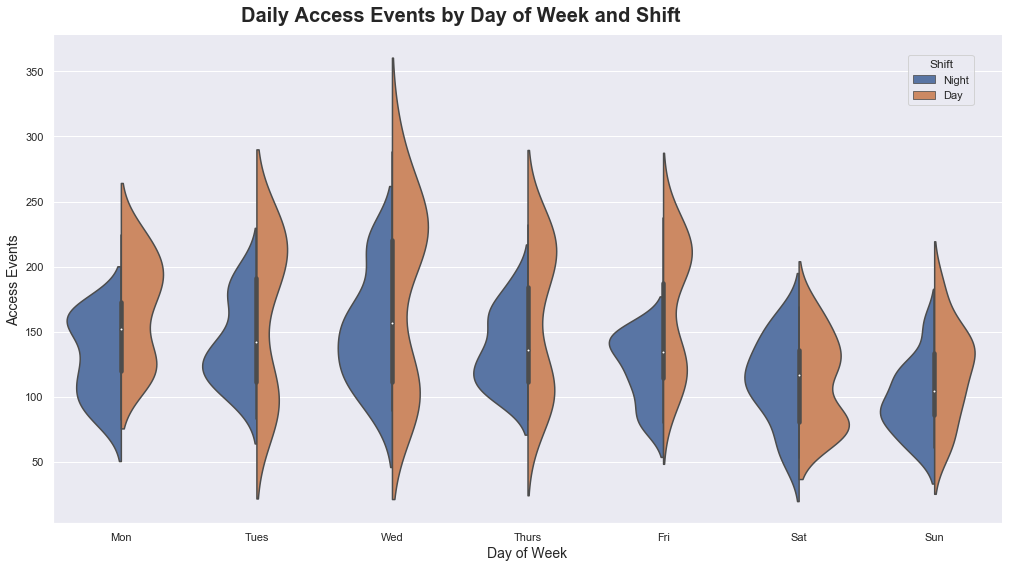

In [52]:
a = sns.catplot(data=plot_data, x='dayofweek', y='access_events',hue='is_day_shift', kind='violin', bw=0.5, split=True, legend_out=False)
xlabels = [day_name_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week and Shift', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Day of Week', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Night','Day']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Shift')

[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tues'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thurs'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

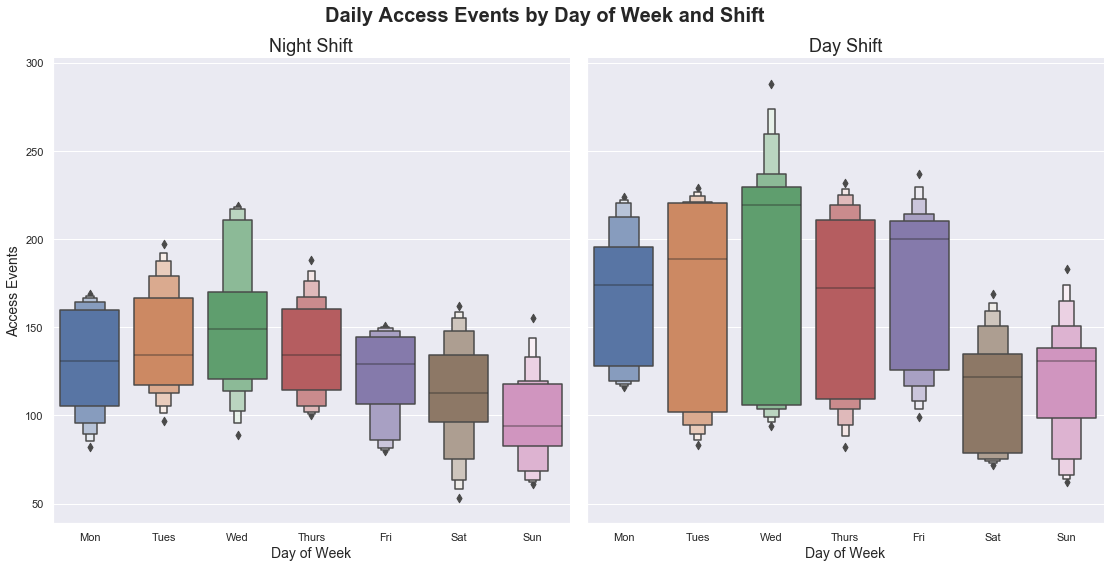

In [53]:
a = sns.catplot(data=plot_data, x='dayofweek', y='access_events',col='is_day_shift', kind='boxen', k_depth='full')
a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week and Shift', fontsize=20, weight='bold', y=1.02)

a.axes[0][0].set_title('Night Shift', fontsize=18)
a.axes[0][0].set_xlabel('Day of Week', fontsize=14)
a.axes[0][0].set_xticklabels(xlabels)
a.axes[0][0].set_ylabel('Access Events', fontsize=14)

a.axes[0][1].set_title('Day Shift', fontsize=18)
a.axes[0][1].set_xlabel('Day of Week', fontsize=14)
a.axes[0][1].set_xticklabels(xlabels)

[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tues'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thurs'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

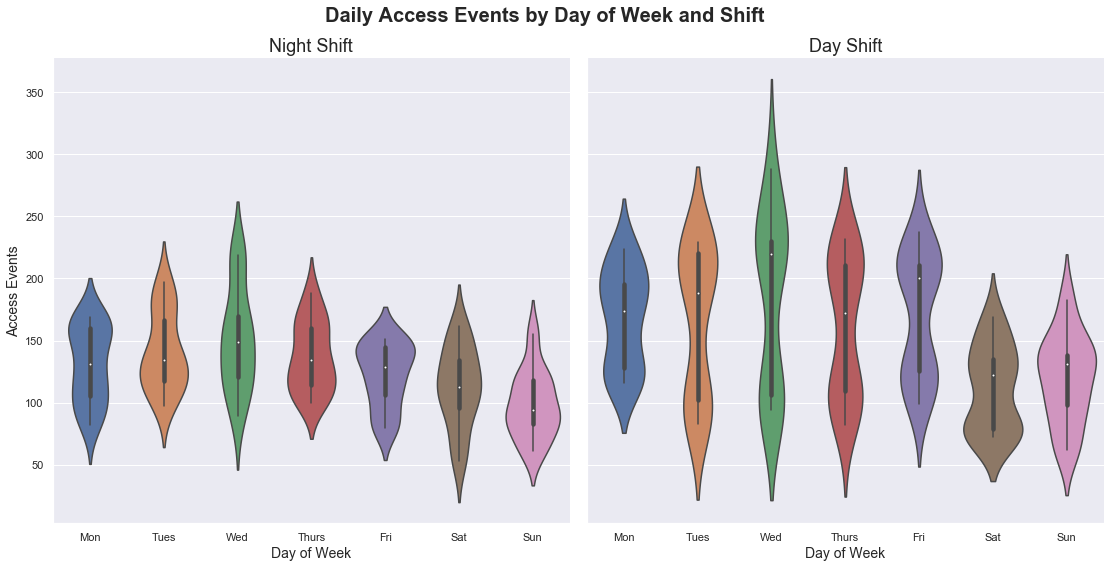

In [54]:
a = sns.catplot(data=plot_data, x='dayofweek', y='access_events',col='is_day_shift', kind='violin', bw=0.5)
a.fig.set_size_inches(16,8)
a.fig.suptitle('Daily Access Events by Day of Week and Shift', fontsize=20, weight='bold', y=1.02)

a.axes[0][0].set_title('Night Shift', fontsize=18)
a.axes[0][0].set_xlabel('Day of Week', fontsize=14)
a.axes[0][0].set_xticklabels(xlabels)
a.axes[0][0].set_ylabel('Access Events', fontsize=14)

a.axes[0][1].set_title('Day Shift', fontsize=18)
a.axes[0][1].set_xlabel('Day of Week', fontsize=14)
a.axes[0][1].set_xticklabels(xlabels)

## Hour of Day

Text(0, 0.5, 'Access Events')

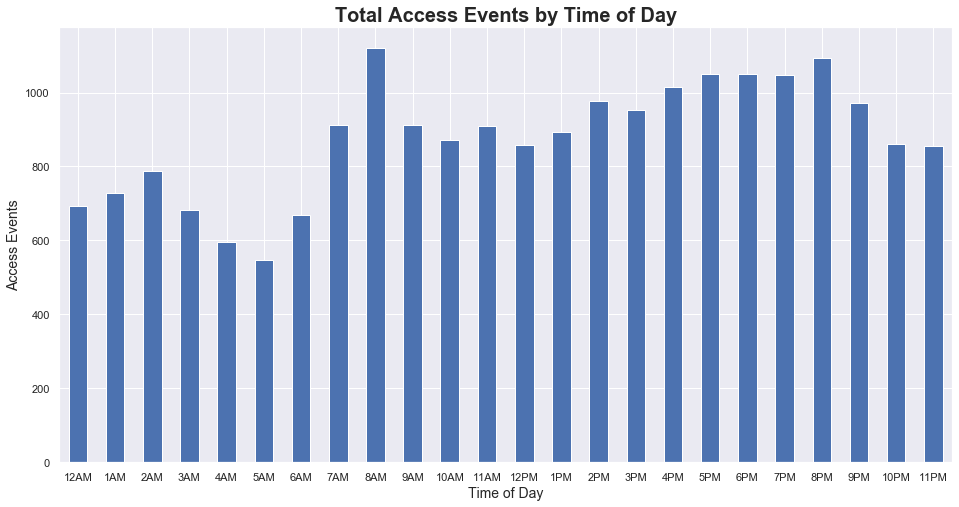

In [55]:
ax = supply_records_master.groupby(['hour']).count()['event_id'].plot(figsize=(16,8),kind='bar')
xlabels = [hour_dict[int(item.get_text())] for item in ax.get_xticklabels()]

ax.set_title('Total Access Events by Time of Day', fontsize=20, fontweight='bold')
ax.set_xlabel('Time of Day', fontsize=14)
ax.set_xticklabels(xlabels, rotation=0)
ax.set_ylabel('Access Events', fontsize=14)

In [56]:
plot_levels = ['year','month','day','hour']
plot_data = get_plot_data(plot_levels)
plot_data.head()

,year,month,day,hour,access_events
0,2023,4,1,0,11
1,2023,4,1,1,7
2,2023,4,1,2,11
3,2023,4,1,3,12
4,2023,4,1,4,11


Text(0, 0.5, 'Access Events')

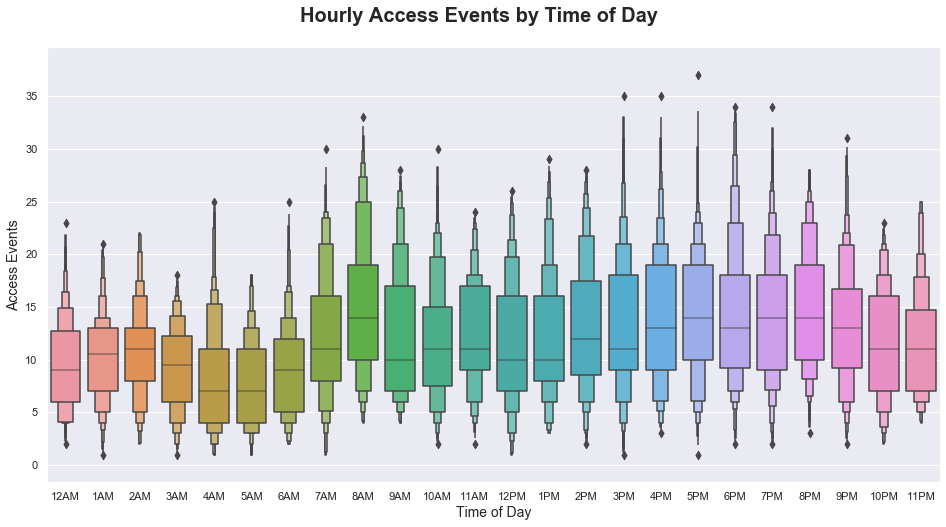

In [57]:
a = sns.boxenplot(data=plot_data, x='hour', y='access_events', k_depth='full')
xlabels = [hour_dict[int(item.get_text())] for item in a.get_xticklabels()]

a.figure.set_size_inches(16,8)
a.figure.suptitle('Hourly Access Events by Time of Day', fontsize=20, weight='bold', y=0.95)
a.set_xlabel('Time of Day', fontsize=14)
a.set_xticklabels(xlabels)
a.set_ylabel('Access Events', fontsize=14)

Text(0, 0.5, 'Access Events')

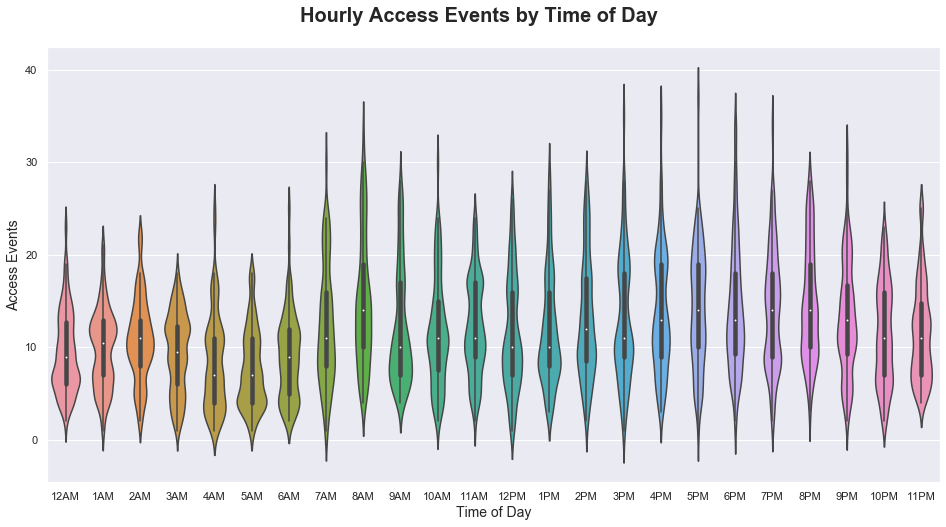

In [58]:
a = sns.violinplot(data=plot_data, x='hour', y='access_events', bw=0.25)
xlabels = [hour_dict[int(item.get_text())] for item in a.get_xticklabels()]

a.figure.set_size_inches(16,8)
a.figure.suptitle('Hourly Access Events by Time of Day', fontsize=20, weight='bold', y=0.95)
a.set_xlabel('Time of Day', fontsize=14)
a.set_xticklabels(xlabels)
a.set_ylabel('Access Events', fontsize=14)

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 5.4% of the points cannot be placed; you ma

Text(20.800000000000004, 0.5, 'Access Events')

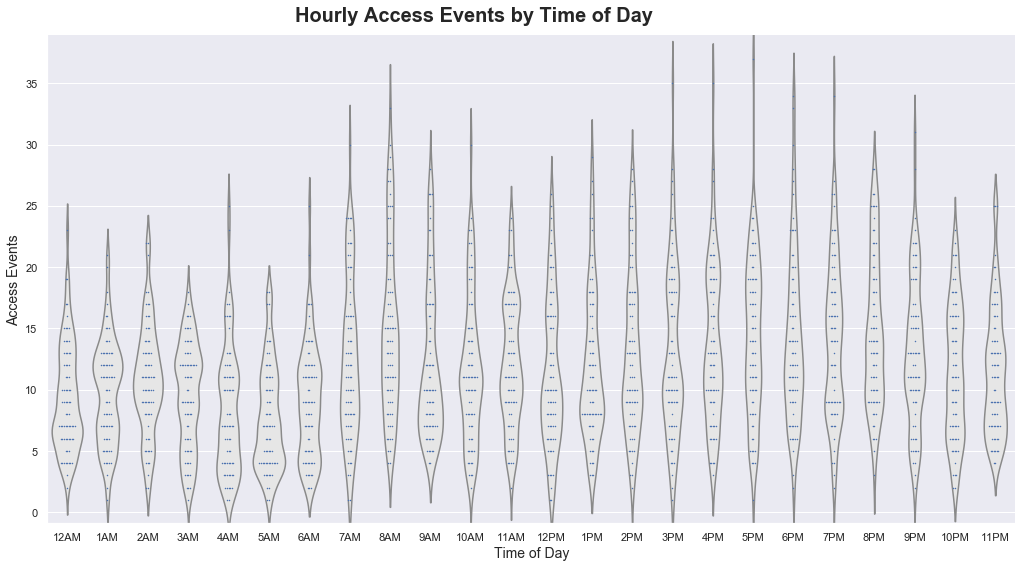

In [59]:
a = sns.catplot(data=plot_data, x="hour", y="access_events", kind="violin", color=".9", inner=None, bw=0.25)
b = sns.swarmplot(data=plot_data, x="hour", y="access_events", size=1.5)
xlabels = [hour_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.figure.set_size_inches(16,8)
a.figure.suptitle('Hourly Access Events by Time of Day', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Time of Day', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

In [60]:
plot_levels = ['year','month','day','hour','is_weekday']
plot_data = get_plot_data(plot_levels)
plot_data.head()

,year,month,day,hour,is_weekday,access_events
0,2023,4,1,0,0,11
1,2023,4,1,1,0,7
2,2023,4,1,2,0,11
3,2023,4,1,3,0,12
4,2023,4,1,4,0,11


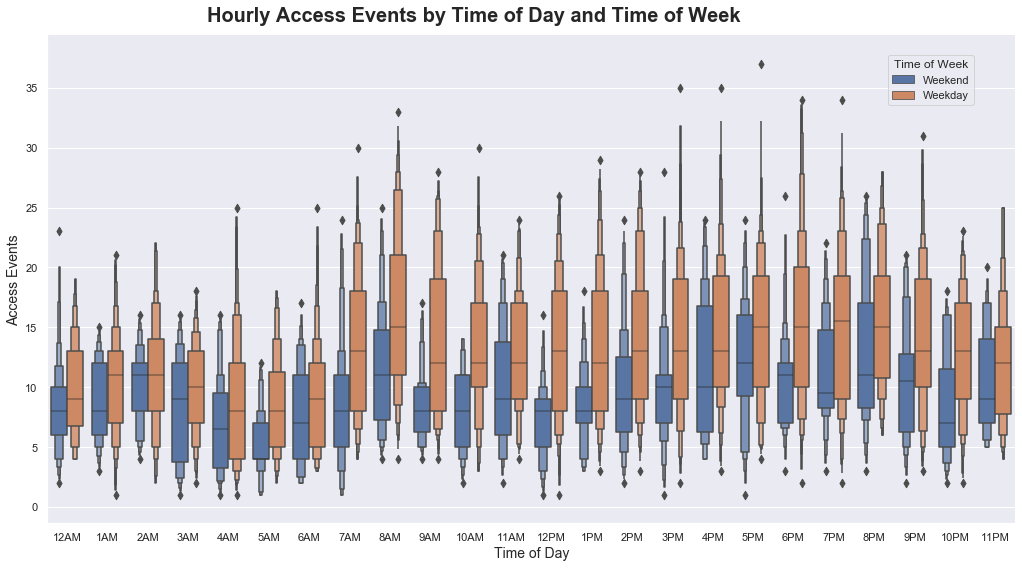

In [61]:
a = sns.catplot(data=plot_data, x='hour', y='access_events',hue='is_weekday', kind='boxen', k_depth='full', legend_out=False)
xlabels = [hour_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Hourly Access Events by Time of Day and Time of Week', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Time of Day', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Weekend','Weekday']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Time of Week')

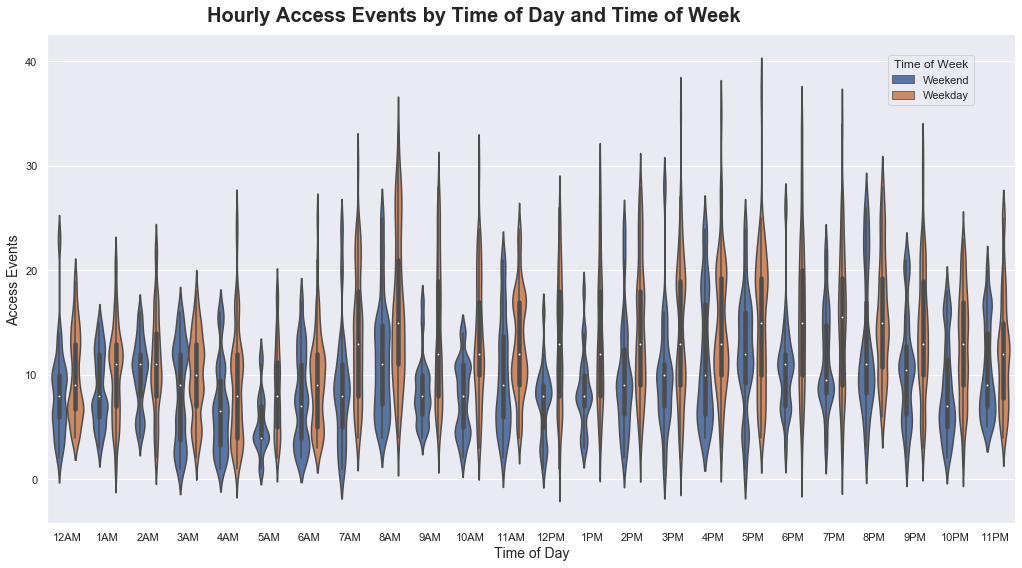

In [62]:
a = sns.catplot(data=plot_data, x='hour', y='access_events',hue='is_weekday', kind='violin', bw=0.25, legend_out=False)
xlabels = [hour_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Hourly Access Events by Time of Day and Time of Week', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Time of Day', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Weekend','Weekday']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Time of Week')

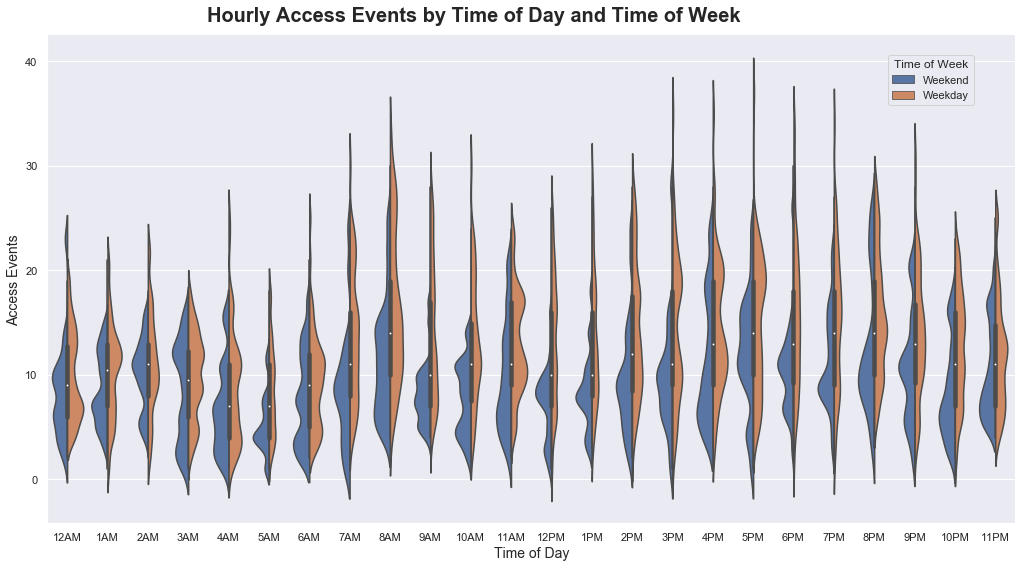

In [63]:
a = sns.catplot(data=plot_data, x='hour', y='access_events',hue='is_weekday', kind='violin', bw=0.25, split=True, legend_out=False)
xlabels = [hour_dict[int(item.get_text())] for item in a.ax.get_xticklabels()]

a.fig.set_size_inches(16,8)
a.fig.suptitle('Hourly Access Events by Time of Day and Time of Week', fontsize=20, weight='bold', y=1.02)
a.ax.set_xlabel('Time of Day', fontsize=14)
a.ax.set_xticklabels(xlabels)
a.ax.set_ylabel('Access Events', fontsize=14)

labels=['Weekend','Weekday']
for text,label in zip(a._legend.texts, labels):
    text.set_text(label)
sns.move_legend(a, loc='upper right', bbox_to_anchor=(0.85,0.9), title='Time of Week')

[Text(0, 0, '12AM'),
 Text(1, 0, '1AM'),
 Text(2, 0, '2AM'),
 Text(3, 0, '3AM'),
 Text(4, 0, '4AM'),
 Text(5, 0, '5AM'),
 Text(6, 0, '6AM'),
 Text(7, 0, '7AM'),
 Text(8, 0, '8AM'),
 Text(9, 0, '9AM'),
 Text(10, 0, '10AM'),
 Text(11, 0, '11AM'),
 Text(12, 0, '12PM'),
 Text(13, 0, '1PM'),
 Text(14, 0, '2PM'),
 Text(15, 0, '3PM'),
 Text(16, 0, '4PM'),
 Text(17, 0, '5PM'),
 Text(18, 0, '6PM'),
 Text(19, 0, '7PM'),
 Text(20, 0, '8PM'),
 Text(21, 0, '9PM'),
 Text(22, 0, '10PM'),
 Text(23, 0, '11PM')]

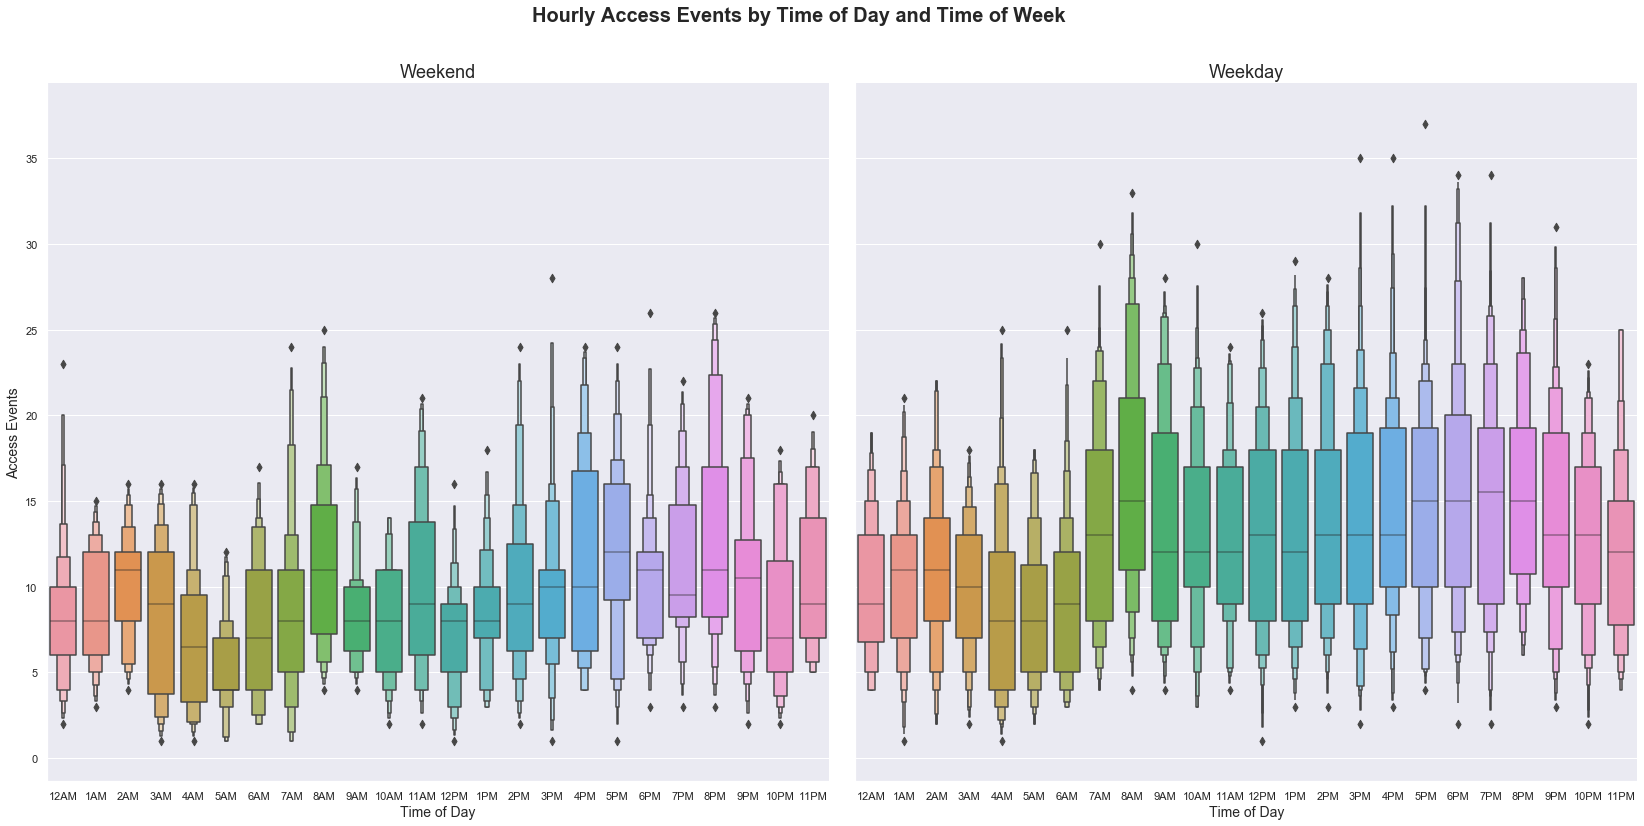

In [64]:
a = sns.catplot(data=plot_data, x='hour', y='access_events',col='is_weekday', kind='boxen',k_depth='full')
a.fig.set_size_inches(24,12)
a.fig.suptitle('Hourly Access Events by Time of Day and Time of Week', fontsize=20, weight='bold', y=1.02)

a.axes[0][0].set_title('Weekend', fontsize=18)
a.axes[0][0].set_xlabel('Time of Day', fontsize=14)
a.axes[0][0].set_xticklabels(xlabels)
a.axes[0][0].set_ylabel('Access Events', fontsize=14)

a.axes[0][1].set_title('Weekday', fontsize=18)
a.axes[0][1].set_xlabel('Time of Day', fontsize=14)
a.axes[0][1].set_xticklabels(xlabels)

[Text(0, 0, '12AM'),
 Text(1, 0, '1AM'),
 Text(2, 0, '2AM'),
 Text(3, 0, '3AM'),
 Text(4, 0, '4AM'),
 Text(5, 0, '5AM'),
 Text(6, 0, '6AM'),
 Text(7, 0, '7AM'),
 Text(8, 0, '8AM'),
 Text(9, 0, '9AM'),
 Text(10, 0, '10AM'),
 Text(11, 0, '11AM'),
 Text(12, 0, '12PM'),
 Text(13, 0, '1PM'),
 Text(14, 0, '2PM'),
 Text(15, 0, '3PM'),
 Text(16, 0, '4PM'),
 Text(17, 0, '5PM'),
 Text(18, 0, '6PM'),
 Text(19, 0, '7PM'),
 Text(20, 0, '8PM'),
 Text(21, 0, '9PM'),
 Text(22, 0, '10PM'),
 Text(23, 0, '11PM')]

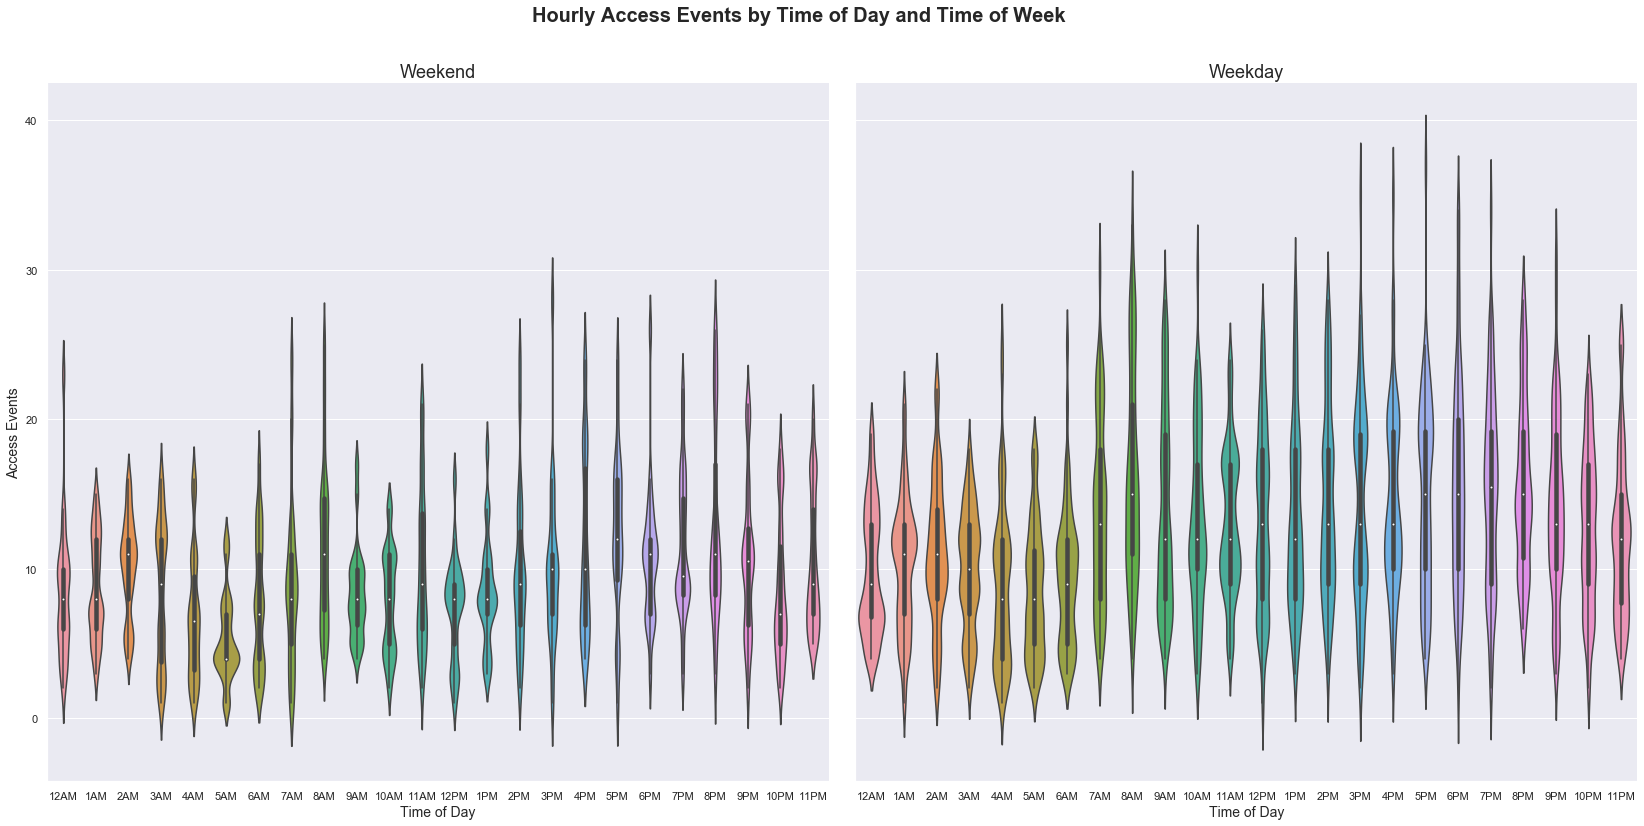

In [65]:
a = sns.catplot(data=plot_data, x='hour', y='access_events',col='is_weekday', kind='violin', bw=0.25)
a.fig.set_size_inches(24,12)
a.fig.suptitle('Hourly Access Events by Time of Day and Time of Week', fontsize=20, weight='bold', y=1.02)

a.axes[0][0].set_title('Weekend', fontsize=18)
a.axes[0][0].set_xlabel('Time of Day', fontsize=14)
a.axes[0][0].set_xticklabels(xlabels)
a.axes[0][0].set_ylabel('Access Events', fontsize=14)

a.axes[0][1].set_title('Weekday', fontsize=18)
a.axes[0][1].set_xlabel('Time of Day', fontsize=14)
a.axes[0][1].set_xticklabels(xlabels)

## Experimental

### Heatmaps and Clustermaps

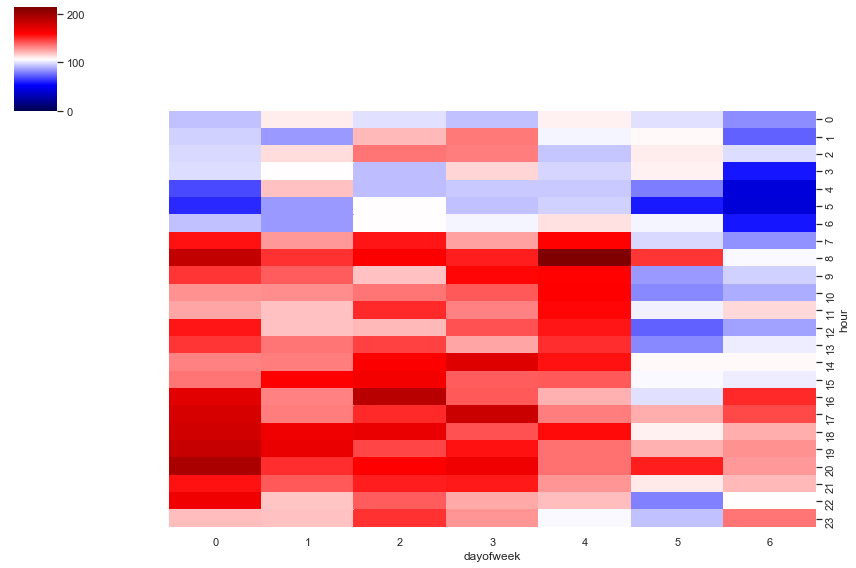

In [66]:
supply_day_hour = supply_records_master.groupby(['hour','dayofweek'])[['event_id']].count().unstack()
supply_day_hour = supply_day_hour.droplevel(level=0, axis=1)
ax = sns.clustermap(supply_day_hour, figsize=(12,8), col_cluster=False, row_cluster=False, cmap='seismic', vmin=0)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


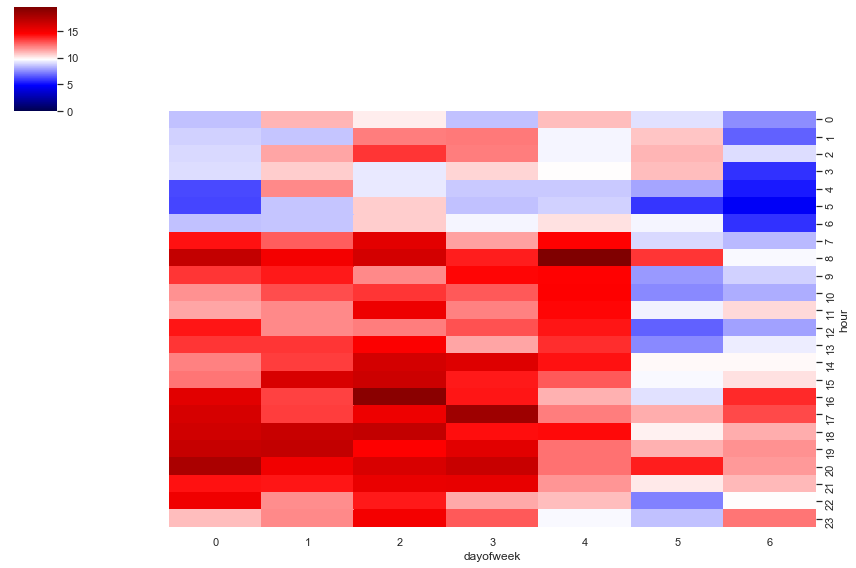

In [67]:
supply_day_hour_daily = supply_records_master.groupby(['month','day','hour','dayofweek'])[['event_id']].count().unstack(level=-2).reset_index(level=-1).groupby(['dayofweek']).mean().droplevel(level=0, axis=1).transpose()
ax = sns.clustermap(supply_day_hour_daily, figsize=(12,8), col_cluster=False, row_cluster=False, cmap='seismic', vmin=0)

In [68]:
supply_records_master.groupby(['is_weekday'])[['event_id']].count()

,event_id
is_weekday,
0,4858
1,16195


In [69]:
supply_records_master.groupby(['is_day_shift'])[['event_id']].count()

,event_id
is_day_shift,
0,9532
1,11521


In [70]:
supply_records_master.groupby(['is_weekday','is_day_shift'])[['event_id']].count()

event_id
is_weekday is_day_shift          
0          0                 2319
           1                 2539
1          0                 7213
           1                 8982

## Flow Data
* Alluvial and sankey plots

In [645]:
idx_names = ['supply_room_id','month','day','hour','dayofweek','is_weekday','is_day_shift','is_top_10']
idx_labels = ['Supply Room','Month','Day of Month','Time of Day','Day of Week','Time of Week','Shift', 'Top 10% Users']
idx_dict = dict(zip(idx_names,idx_labels))

# Create flow data
flow_data = supply_records_master.groupby(['supply_room_id','month','day','hour','dayofweek','is_weekday','is_day_shift','is_top_10'])[['event_id']].count()
flow_data = flow_data.sort_index()

# Rename sorted idx values
flow_data = flow_data.rename(index=month_dict, level='month')
flow_data = flow_data.rename(index=hour_dict, level='hour')
flow_data = flow_data.rename(index=day_name_dict, level='dayofweek')
flow_data = flow_data.rename(index={1:'Weekday',0:'Weekend'}, level='is_weekday')
flow_data = flow_data.rename(index={1:'Day Shift',0:'Night Shift'}, level='is_day_shift')
flow_data = flow_data.rename(index={1:'Top 10% Users',0:'Bottom 90% Users'}, level='is_top_10')

# Rename idx labels
flow_data = flow_data.rename(columns={'event_id': 'Access Events'})
flow_data.index = flow_data.index.rename(idx_dict)

In [646]:
print(len(flow_data))
print(len(flow_data.columns))
flow_data.head()

2900
1


Access Events
Supply Room Month Day of Month Time of Day Day of Week Time of Week Shift       Top 10% Users                  
477244      Apr   1            12AM        Sat         Weekend      Night Shift Bottom 90% Users              1
                               1AM         Sat         Weekend      Night Shift Bottom 90% Users              2
                               2AM         Sat         Weekend      Night Shift Bottom 90% Users              2
                               3AM         Sat         Weekend      Night Shift Bottom 90% Users              4
                               4AM         Sat         Weekend      Night Shift Bottom 90% Users              3

### Sankey
* Really it's an alluvial plot right now

In [647]:
temp_flow = flow_data.copy()
temp_flow = temp_flow.groupby(axis=0, level=[0,1,5,6]).sum()

In [648]:
node_label = [item for level in range(temp_flow.index.nlevels) for item in temp_flow.index.unique(level=level)]   
node_color = ['rgba(' + RGB_GREY + ',' + NODE_ALPHA + ')']*len(node_label)
node_idx = range(len(node_label))
node_idx_dict = dict(zip(node_label,node_idx))

node_data = list(zip(node_label,node_color,node_idx))
nodes = pd.DataFrame(node_data, columns=['label','color','idx'] )

In [649]:
link_data = []
for idx,row in temp_flow.iterrows():
    color_key = idx[0]
    color = 'rgba(' + color_dict[color_key] + ',' + LINK_ALPHA + ')'
    
    path = '-->'.join(idx)
    label = '-->'.join(idx)
    value = row[0]
    
    for i in range(len(idx)-1):
        source_key = idx[i]
        source = node_idx_dict[source_key]

        target_key = idx[i+1]
        target = node_idx_dict[target_key]
        
        link_data.append([source,target,color,path,label,value])
links = pd.DataFrame(link_data, columns=['source','target','color','path','label','value'])

In [650]:
print(len(temp_flow))
print(len(temp_flow.columns))
temp_flow.head(2)

24
1


Access Events
Supply Room Month Time of Week Shift                     
477244      Apr   Weekday      Day Shift             2054
                               Night Shift           1472

In [651]:
print(len(nodes))
print(len(nodes.columns))
nodes.head(2)

9
3


,label,color,idx
0,477244,"rgba(192,192,192,0.8)",0
1,477245,"rgba(192,192,192,0.8)",1


In [652]:
print(len(links))
print(len(links.columns))
links.head(2)

72
6


,source,target,color,path,label,value
0,0,2,"rgba(0,0,255,0.2)",477244-->Apr-->Weekday-->Day Shift,477244-->Apr-->Weekday-->Day Shift,2054
1,2,5,"rgba(0,0,255,0.2)",477244-->Apr-->Weekday-->Day Shift,477244-->Apr-->Weekday-->Day Shift,2054


In [653]:
def get_sankey_diagram(nodes, links, title):
    fig = go.Figure(
        data = [go.Sankey(
            valueformat = "4d",
            valuesuffix = "Events",
            # Define nodes
            node = dict(
              pad = 15,
              thickness = 15,
              line = dict(color = "black", width = 0.5),
              label =  nodes['label'].to_list(),
              color =  nodes['color'].to_list()
            ),
            # Add links
            link = dict(
              source = links['source'].to_list(),
              target = links['target'].to_list(),
              value = links['value'].to_list(),
              label = links['label'].to_list(),
              color = links['color'].to_list()))],
        layout = dict(
            height = 800,
            width = 1000
        )
    )

    fig.update_layout(title_text=title,
                      font_size=10)
    fig.show()

In [654]:
title = 'temp'
get_sankey_diagram(nodes, links, title)

### Parallel Coordinates

In [ ]:
supply_records_master.head(2)

In [82]:
plot_levels = ['month','day','dayofweek','supply_room_id']
temp_df = get_plot_data(plot_levels)
temp_df['supply_room_id'] = temp_df['supply_room_id'].astype('int64')
midpoint = temp_df['access_events'].median()

In [83]:
temp_df.head()

,month,day,dayofweek,supply_room_id,access_events
0,4,1,5,477244,109
1,4,1,5,477245,168
2,4,2,6,477244,113
3,4,2,6,477245,141
4,4,3,0,477244,150


In [84]:
fig = px.parallel_coordinates(temp_df, color="access_events",
                              dimensions=['day','month','access_events','supply_room_id'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=midpoint)
fig.show()

### Treemap
* To be implemented if time allows - may not be necessary with sankey/alluvial and parallel coords plots

In [290]:
# Default treemap example for reference 
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/96c0bd/sunburst-coffee-flavors-complete.csv')

In [292]:
df.head()

,ids,labels,parents
0,Coffee,Coffee Flavors,NaN
1,Aromas,Aromas,Coffee
2,Tastes,Tastes,Coffee
3,Aromas-Enzymatic,Enzymatic,Aromas
4,Aromas-Sugar Browning,Sugar Browning,Aromas


In [291]:
fig = go.Figure(go.Treemap(
    ids = df.ids,
    labels = df.labels,
    parents = df.parents,
    pathbar_textfont_size=15,
    root_color="lightgrey"
))
fig.update_layout(
    uniformtext=dict(minsize=10, mode='hide'),
    margin = dict(t=50, l=25, r=25, b=25)
)
fig.show()

## Summary Stats

In [87]:
# see "cobalt_critical_analytics.ipynb" for advanced multi-indexing, aggregation, and relative percentage functions
supply_summary = supply_records_master.groupby(['month','day','hour','dayofweek','card_id','supply_room_id','status'])[['event_id']].count()
supply_summary = supply_summary.rename(columns={'event_id':'access_events'})
supply_summary.head(2)

access_events
month day hour dayofweek card_id supply_room_id status                 
4     1   0    5         159198  477245         Admitted              1
                         187807  477245         Admitted              1

In [88]:
supply_summary.groupby(level=[5]).sum()

,access_events
supply_room_id,
477244,7214
477245,13839


In [89]:
supply_summary.groupby(level=[5,0]).sum()

access_events
supply_room_id month               
477244         4               4729
               5               2218
               6                267
477245         4               5518
               5               2504
               6               5817

In [90]:
supply_summary.groupby(level=[0]).sum()

,access_events
month,
4,10247
5,4722
6,6084


In [91]:
# compare first 15 days of april to may
len(supply_records_master[(supply_records_master['month']==4) & (supply_records_master['day']<=15)])

5088

In [93]:
# How are access events distributed among card holders
num_supply_records = len(supply_records_master)
num_card_ids = len(supply_records_master.groupby(['card_id'])[['event_id']].count().sort_values('event_id',ascending=False))
top_10pct_card_ids = int(num_card_ids*0.1)
top_20pct_card_ids = int(num_card_ids*0.2)
top_10pct_events = supply_records_master.groupby(['card_id'])[['event_id']].count().sort_values('event_id',ascending=False).head(top_10pct_card_ids).sum()
top_20pct_events = supply_records_master.groupby(['card_id'])[['event_id']].count().sort_values('event_id',ascending=False).head(top_20pct_card_ids).sum()

In [94]:
# Looks like the 80/20 rule in action to me!
print('Top 10% of card id\'s:',round(top_10pct_events.values[0]/num_supply_records,4)*100, 'percent of all access events.')
print('Top 20% of card id\'s:',round(top_20pct_events.values[0]/num_supply_records,4)*100, 'percent of all access avents.')

Top 10% of card id's: 58.14 percent of all access events.
Top 20% of card id's: 78.63 percent of all access avents.


### Deadweight Loss

In [97]:
dw_loss_data = []

estimated_round_trip_minutes = [52.5/60, 102.25/60, 152/60, 3, 4]

for trip_time in estimated_round_trip_minutes:
    print('Estimated round trip time to supply closet:',trip_time,'minutes')

    dw_loss = supply_summary.groupby(level=[5,0]).sum()
    dw_loss['access_minutes'] = dw_loss['access_events']*trip_time
    dw_loss['access_hours'] = dw_loss['access_minutes']/60
    dw_loss['access_24h_days'] = dw_loss['access_hours']/24
    dw_loss['access_FTE_work_weeks'] = dw_loss['access_hours']/40
    dw_loss = pd.concat({str(round(trip_time,3)): dw_loss}, names=['trip_time_minutes'])
    
    dw_loss_data.append(dw_loss)

Estimated round trip time to supply closet: 0.875 minutes
Estimated round trip time to supply closet: 1.7041666666666666 minutes
Estimated round trip time to supply closet: 2.533333333333333 minutes
Estimated round trip time to supply closet: 3 minutes
Estimated round trip time to supply closet: 4 minutes


In [98]:
dw_loss_results = pd.concat(dw_loss_data)
dw_loss_results

access_events  access_minutes  \
trip_time_minutes supply_room_id month                                  
0.875             477244         4               4729       4137.8750   
                                 5               2218       1940.7500   
                                 6                267        233.6250   
                  477245         4               5518       4828.2500   
                                 5               2504       2191.0000   
                                 6               5817       5089.8750   
1.704             477244         4               4729       8059.0042   
                                 5               2218       3779.8417   
                                 6                267        455.0125   
                  477245         4               5518       9403.5917   
                                 5               2504       4267.2333   
                                 6               5817       9913.1375   
2.533             477244         4               4729      11980.1333   
                                 5               2218       5618.9333   
                                 6                267        676.4000   
                  477245         4               5518      13978.9333   
                                 5               2504       6343.4667   
                                 6               5817      14736.4000   
3                 477244         4               4729      14187.0000   
                                 5               2218       6654.0000   
                                 6                267        801.0000   
                  477245         4               5518      16554.0000   
                                 5               2504       7512.0000   
                                 6               5817      17451.0000   
4                 477244         4               4729      18916.0000   
                                 5               2218       8872.0000   
                                 6                267       1068.0000   
                  477245         4               5518      22072.0000   
                                 5               2504      10016.0000   
                                 6               5817      23268.0000   

                                        access_hours  access_24h_days  \
trip_time_minutes supply_room_id month                                  
0.875             477244         4           68.9646           2.8735   
                                 5           32.3458           1.3477   
                                 6            3.8937           0.1622   
                  477245         4           80.4708           3.3530   
                                 5           36.5167           1.5215   
                                 6           84.8312           3.5346   
1.704             477244         4          134.3167           5.5965   
                                 5           62.9974           2.6249   
                                 6            7.5835           0.3160   
                  477245         4          156.7265           6.5303   
                                 5           71.1206           2.9634   
                                 6          165.2190           6.8841   
2.533             477244         4          199.6689           8.3195   
                                 5           93.6489           3.9020   
                                 6           11.2733           0.4697   
                  477245         4          232.9822           9.7076   
                                 5          105.7244           4.4052   
                                 6          245.6067          10.2336   
3                 477244         4          236.4500           9.8521   
                                 5          110.9000           4.6208   
                                 6           13.3500           0.5563   
                  477245

#### Total Deadweight Loss
* **Number of FTE work weeks lost due to excessive trips to supply closets** (for various avg. trip times in minutes)
    * Data represents **one ED** with **two supply closets** at a **small/med sized facility** over a **\~2 month period** (not accounting for seasonal/cyclical effects, inventory availability/costs, theft, etc.)
    * Avg. trip times pulled from prior research on ED supply closet trip times and other inefficiencies
    * Assuming \~50 working weeks per year and \~100k *ED nurse salary* (based on market data):
        * Best case (\~0.875 minutes per trip): **\~15% of FTE work weeks, or 15k in revenue, lost every 2 months**
        * Worst case (\~4 minutes per trip): **\~70% of FTE work weeks, or 70k in revenue, lost every 2 months**

In [99]:
dw_loss_results.groupby(level=0).sum()

,access_events,access_minutes,access_hours,access_24h_days,access_FTE_work_weeks
trip_time_minutes,,,,,
0.875,21053,18421.3750,307.0229,12.7926,7.6756
1.704,21053,35877.8208,597.9637,24.9152,14.9491
2.533,21053,53334.2667,888.9044,37.0377,22.2226
3,21053,63159.0000,1052.6500,43.8604,26.3163
4,21053,84212.0000,1403.5333,58.4806,35.0883


### Time between access events
* Need to explore more here

In [100]:
print('Mean: ', round(supply_records_master['timestamp'].diff().mean().seconds/60,2), 'minutes.')
print('Median', round(supply_records_master['timestamp'].diff().median().seconds/60,2), 'minutes.')
print('Standard Deviation', round(supply_records_master['timestamp'].diff().std().seconds/60,2), 'minutes.')
temp_diff = supply_records_master['timestamp'].diff().dropna()
temp_diff_med = temp_diff.median()
print('Median Absolute Deviation', round(pd.Series([abs(diff - temp_diff_med) for diff in temp_diff]).median().seconds/60,2), 'minutes.')
print('Mean Absolute Deviation', round(pd.Series([abs(diff - temp_diff_med) for diff in temp_diff]).mean().seconds/60,2), 'minutes.')

Mean:  6.22 minutes.
Median 2.98 minutes.
Standard Deviation 159.03 minutes.
Median Absolute Deviation 2.12 minutes.
Mean Absolute Deviation 4.9 minutes.


In [101]:
print('Mean: ', round(supply_records_master['timestamp'].diff().mean().seconds/60,2), 'minutes.')
print('Median', round(supply_records_master['timestamp'].diff().median().seconds/60,2), 'minutes.')
print('Standard Deviation', round(supply_records_master['timestamp'].diff().std().seconds/60,2), 'minutes.')
temp_diff = supply_records_master['timestamp'].diff().dropna()
temp_diff_med = temp_diff.median()
print('Median Absolute Deviation', round(pd.Series([abs(diff - temp_diff_med) for diff in temp_diff]).median().seconds/60,2), 'minutes.')
print('Mean Absolute Deviation', round(pd.Series([abs(diff - temp_diff_med) for diff in temp_diff]).mean().seconds/60,2), 'minutes.')

Mean:  6.22 minutes.
Median 2.98 minutes.
Standard Deviation 159.03 minutes.
Median Absolute Deviation 2.12 minutes.
Mean Absolute Deviation 4.9 minutes.


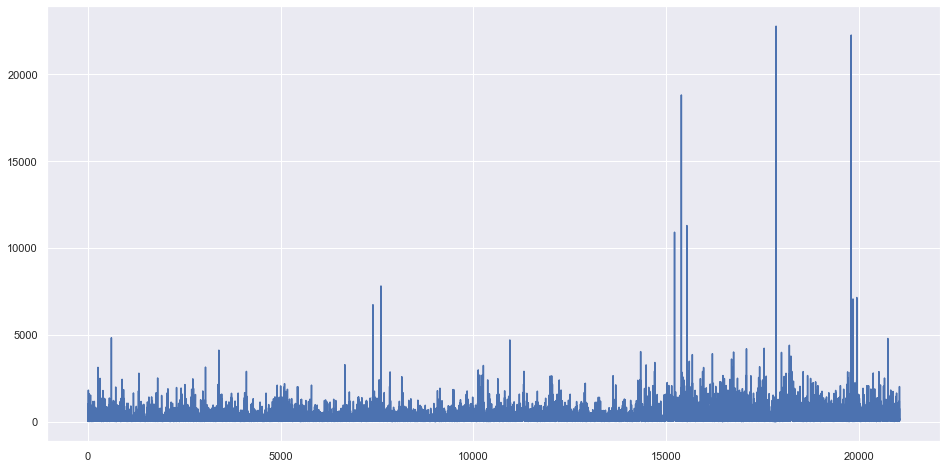

In [279]:
a = (supply_records_master['timestamp'].diff().dt.seconds).plot(figsize=(16,8))

## Time Series

In [102]:
print(len(supply_records_master))
print(len(supply_records_master.columns))
supply_records_master.head(2)

21053
23


,event_id,card_holder,timestamp,status,scope,card_id,facility_id,supply_room_id,supply_room_name,entity_name,year,month,day,hour,dayofweek,dayofyear,year_month,year_month_week,year_month_day,is_weekday,is_day_shift,is_top_10,is_supply_staff
0,e000000,"Choy, Hana E",2023-04-01 00:03:05,Admitted,Global,223904,3997,477245,ACHP 1st Flr Clean Supply Room 1135 Door,Presby Medical Center,2023,4,1,0,5,91,2023-04-01,2023-03-30,2023-04-01,0,0,0,0
1,e000001,"Choy, Hana E",2023-04-01 00:03:12,Admitted,Global,223904,3997,477245,ACHP 1st Flr Clean Supply Room 1135 Door,Presby Medical Center,2023,4,1,0,5,91,2023-04-01,2023-03-30,2023-04-01,0,0,0,0


## Supply Room Access

In [103]:
# See Cobalt Critical Analytics for details on more advanced data tables
#data = supply_records_master.groupby(['year_month_day','supply_room_id']).count()[['event_id']]
#data.columns = pd.MultiIndex.from_product([data.columns, ['Aggregate'],['Total']])
#data

In [104]:
# Ploting data
data = supply_records_master.groupby(['year_month_day','supply_room_id']).count()[['event_id']].unstack()
data = data.droplevel(level=0,axis=1)
data.columns = data.columns.rename(name='Supply Room ID')
data.index = data.index.rename(name='Date')

# X-axis labels
xlabels = []
for date in data.index:
    date_str = str(date.date()).split('-')
    if date.day==1 or date.day==15:
        label = '\n'.join([date_str[2],month_dict[date.month],date_str[0]])
    elif date.day%5==0 and date.day!=30:
        label = '\n'.join([date_str[2],month_dict[date.month]])
    else:
        label = ''
    xlabels.append(label)

In [105]:
print(len(data))
print(len(data.columns))
data.head(2)

75
2


Supply Room ID,477244,477245
Date,,
2023-04-01,109,168
2023-04-02,113,141


Text(0, 0.5, 'Access Events')

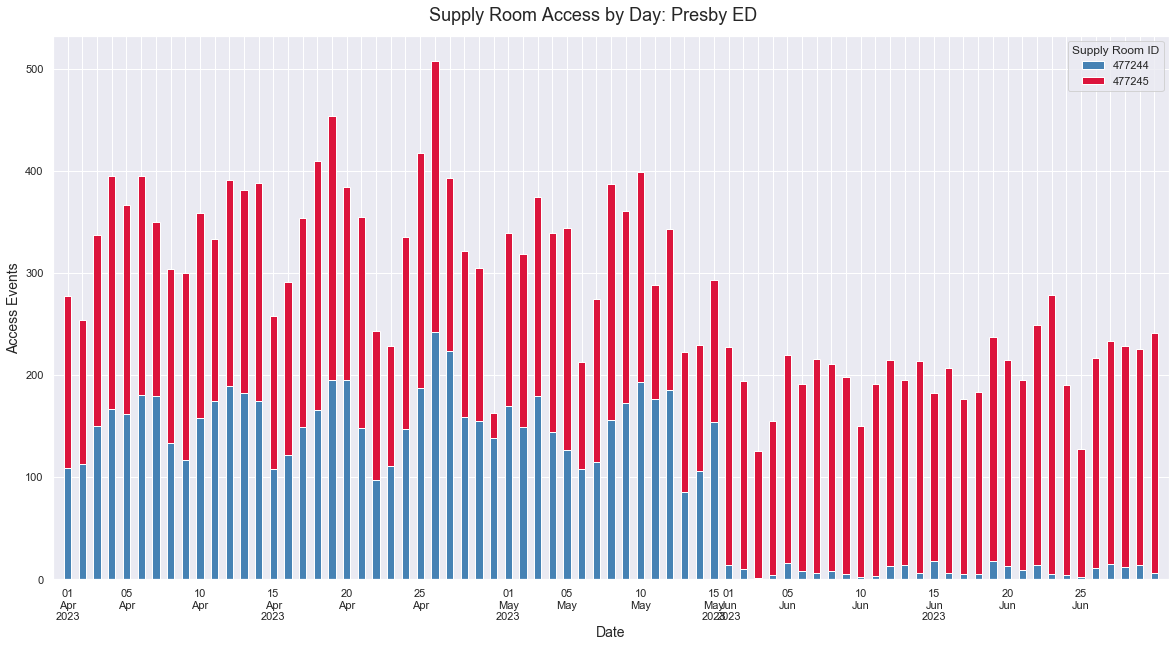

In [106]:
fig, ax = plt.subplots(figsize=(20,10))
plt.grid(True)
width=0.5

stacked_plot = data.plot(ax=ax, kind='bar', stacked=True, width=width, color=['steelblue','crimson'])

fig.suptitle('Supply Room Access by Day: Presby ED', fontsize=18, y=0.92)

ax.set_xlim(-1,len(data))
ax.set_xlabel('Date', fontsize=14)
ax.set_xticklabels(xlabels,rotation=0)

ax.set_ylabel('Access Events', fontsize=14)

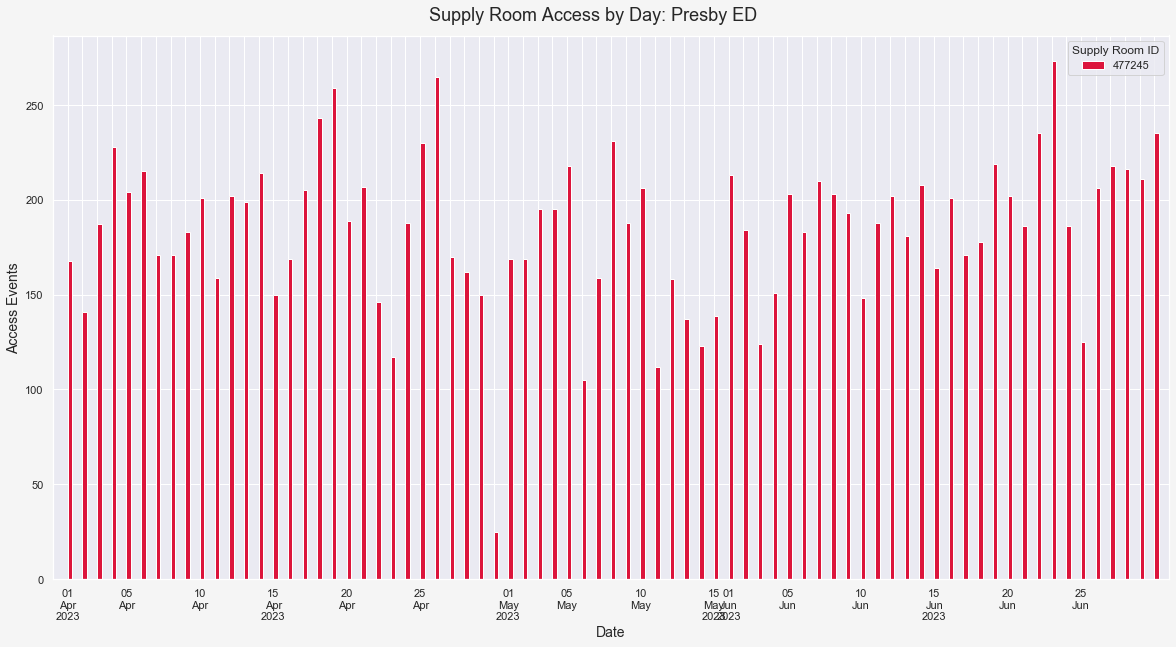

In [107]:
fig, ax = plt.subplots(figsize=(20,10), facecolor='whitesmoke')
plt.grid(True)
width=0.3

#room_477244_plot = data['477244'].plot(ax=ax, kind='bar', width=width, color='steelblue', ec='w', position=1)
room_477245_plot = data['477245'].plot(ax=ax, kind='bar', width=width, color='crimson', ec='w', position=0)

fig.suptitle('Supply Room Access by Day: Presby ED', fontsize=18, y=0.92)

ax.set_xlim(-1,len(data))
ax.set_xlabel('Date', fontsize=14)
ax.set_xticklabels(xlabels,rotation=0)

ax.set_ylabel('Access Events', fontsize=14)

ax.legend(title='Supply Room ID')

# Working

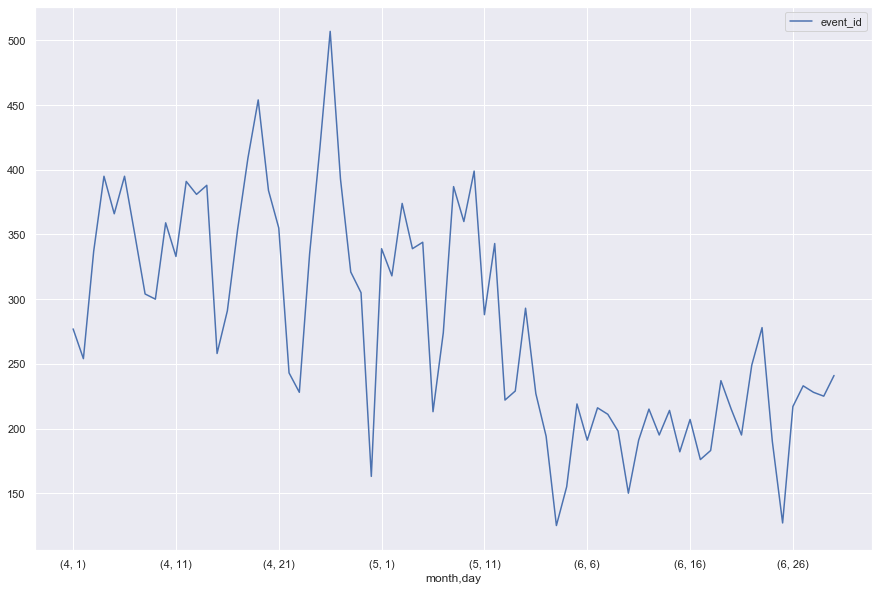

In [108]:
ax = supply_records_master.groupby(['month','day']).count()[['event_id']].plot(figsize=(15,10))

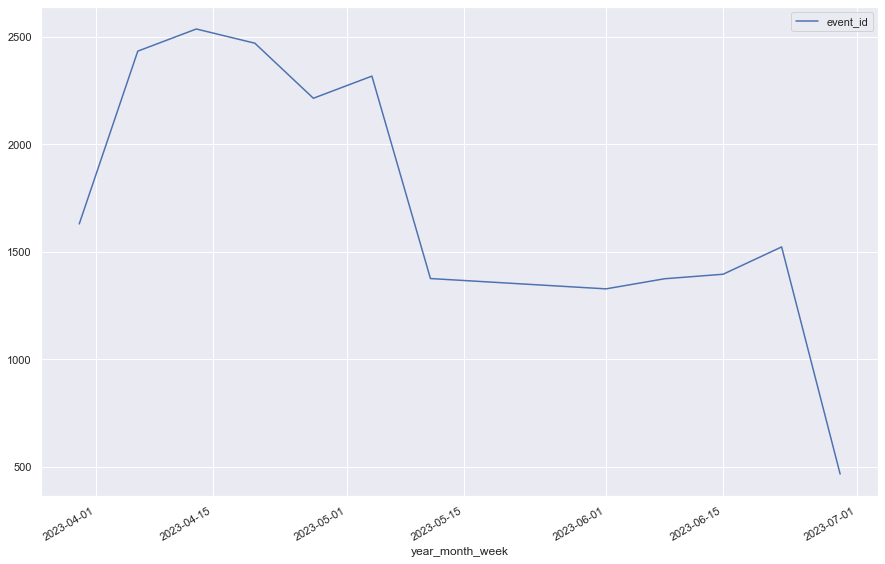

In [109]:
ax = supply_records_master.groupby(['year_month_week']).count()[['event_id']].plot(figsize=(15,10))

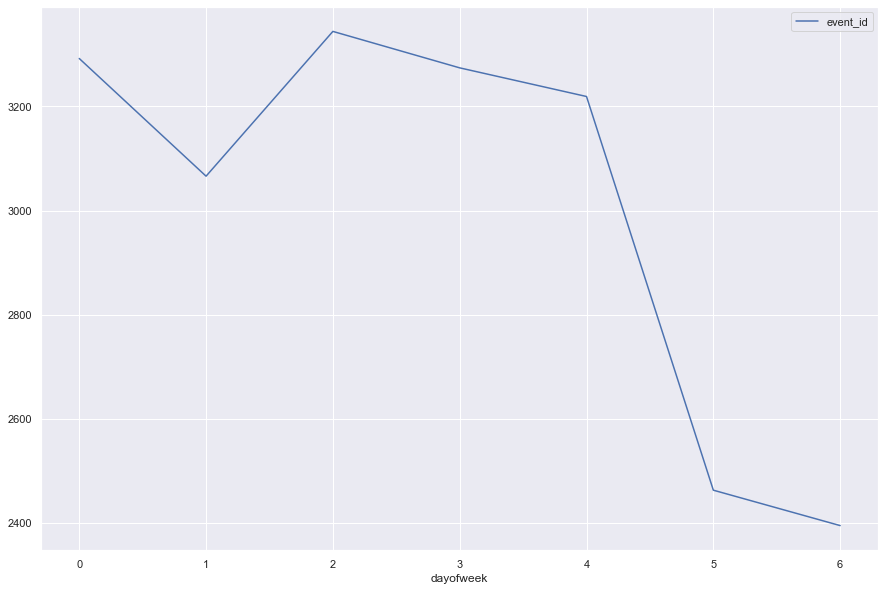

In [110]:
ax = supply_records_master.groupby(['dayofweek']).count()[['event_id']].plot(figsize=(15,10))

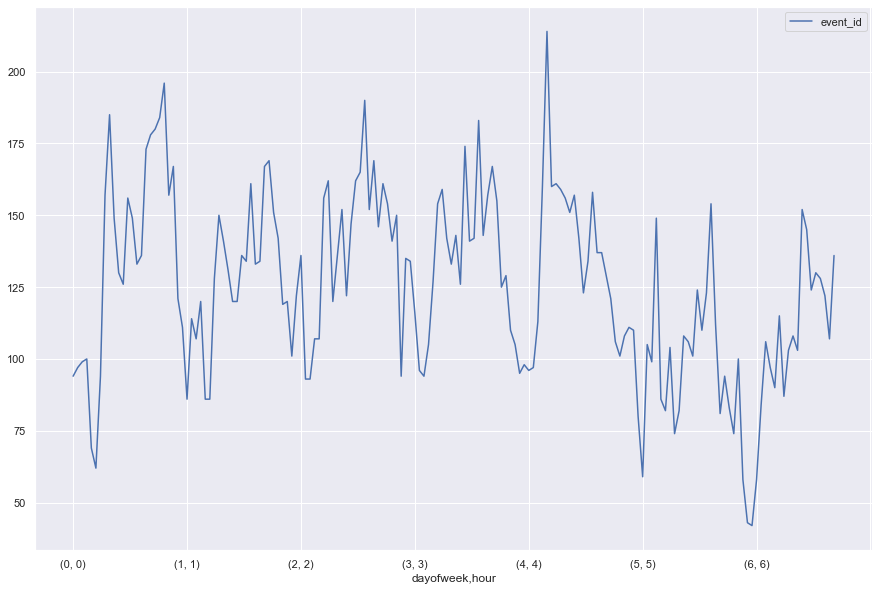

In [111]:
ax = supply_records_master.groupby(['dayofweek','hour']).count()[['event_id']].plot(figsize=(15,10))

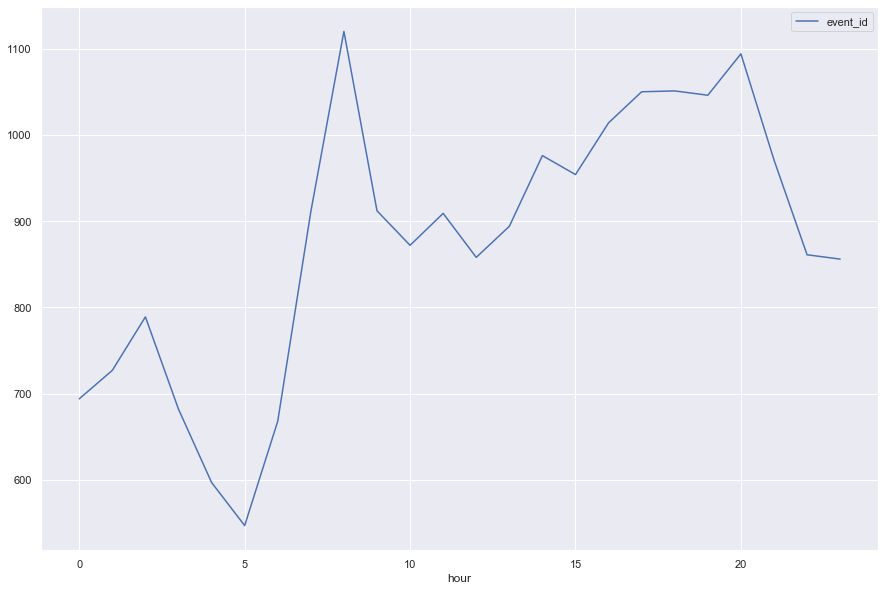

In [112]:
ax = supply_records_master.groupby(['hour']).count()[['event_id']].plot(figsize=(15,10))

In [113]:
print('Number unique card ids:',len(supply_records_master.card_id.unique()))
print('Number of access events by top 20% of card ids:',supply_records_master.groupby(['card_id']).count()['event_id'].sort_values(ascending=False).head(120).sum())
print('Total number of access events:',len(supply_records_master))
supply_records_master.groupby(['card_id']).count()['event_id'].sort_values(ascending=False).head(120)

Number unique card ids: 762
Number of access events by top 20% of card ids: 15131
Total number of access events: 21053


card_id
159215    851
220468    374
243673    347
220896    289
220017    271
243025    252
242069    231
157760    230
242149    228
108264    225
219861    223
219868    218
241750    214
241962    213
251412    205
214588    200
242070    195
243492    190
219746    178
243396    178
220216    177
219402    169
241795    168
187120    165
251742    164
187206    161
220867    160
183363    156
158763    155
220625    154
251561    152
219219    152
242845    152
205276    148
251603    144
108275    144
220611    143
139023    142
219423    141
243490    140
220266    139
220866    139
220210    131
251662    126
242032    124
200144    123
186902    123
108300    123
242082    121
220556    120
219285    115
243349    115
219649    113
220470    111
220253    110
151485    108
220830    107
241898    107
219550    104
159202    101
159194    100
243615     98
219939     97
241866     97
219975     96
219918     96
242210     95
251964     92
242828     92
108282     91
241894     9

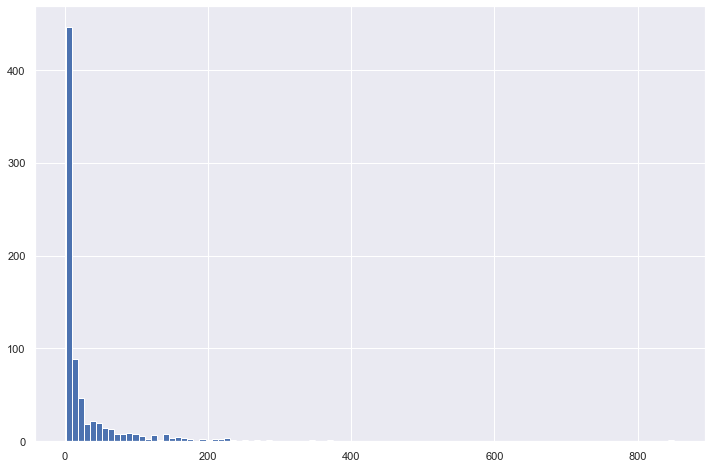

In [114]:
# Access events - linear scale on y-axis
ax = supply_records_master.groupby(['card_id']).count()['event_id'].sort_values(ascending=False).hist(figsize=(12,8), bins=100)

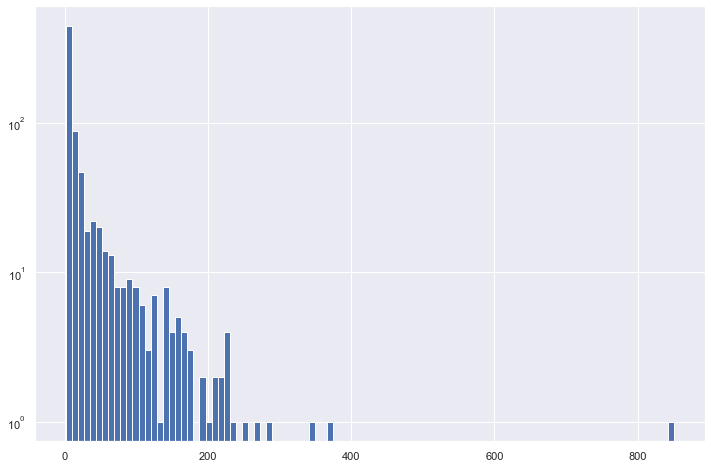

In [115]:
# Access events - log scale on y-axis
ax = supply_records_master.groupby(['card_id']).count()['event_id'].sort_values(ascending=False).hist(figsize=(12,8), bins=100)
ax.set_yscale('log',basey=10)

(0.1, 1000)

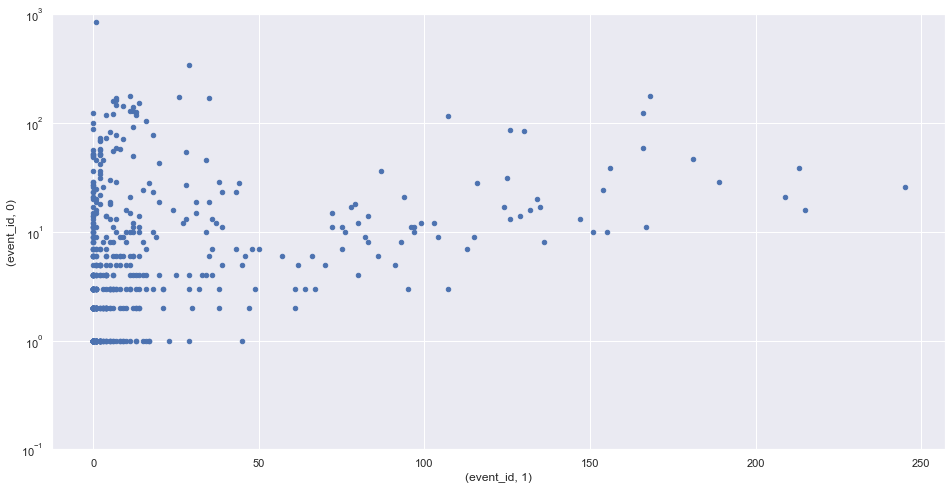

In [623]:
df = supply_records_master.groupby(['card_id','is_day_shift'])[['event_id']].count().unstack().fillna(0)
ax = df.plot(kind='scatter', x=1, y=0, figsize=(16,8))
ax.set_yscale('log',basey=10)
ax.set_ylim(0.1,1000)

In [758]:
# ED Staff only
temp_data_staff = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                  (supply_records_master['month'].isin([4,6]))].groupby(['month','day','hour','is_supply_staff']).count()[['event_id']].unstack(2).fillna(0)
temp_data_staff = temp_data_staff.transpose().droplevel(0).loc[:,idx_slice[:,:,0]].droplevel(axis=1,level=-1)

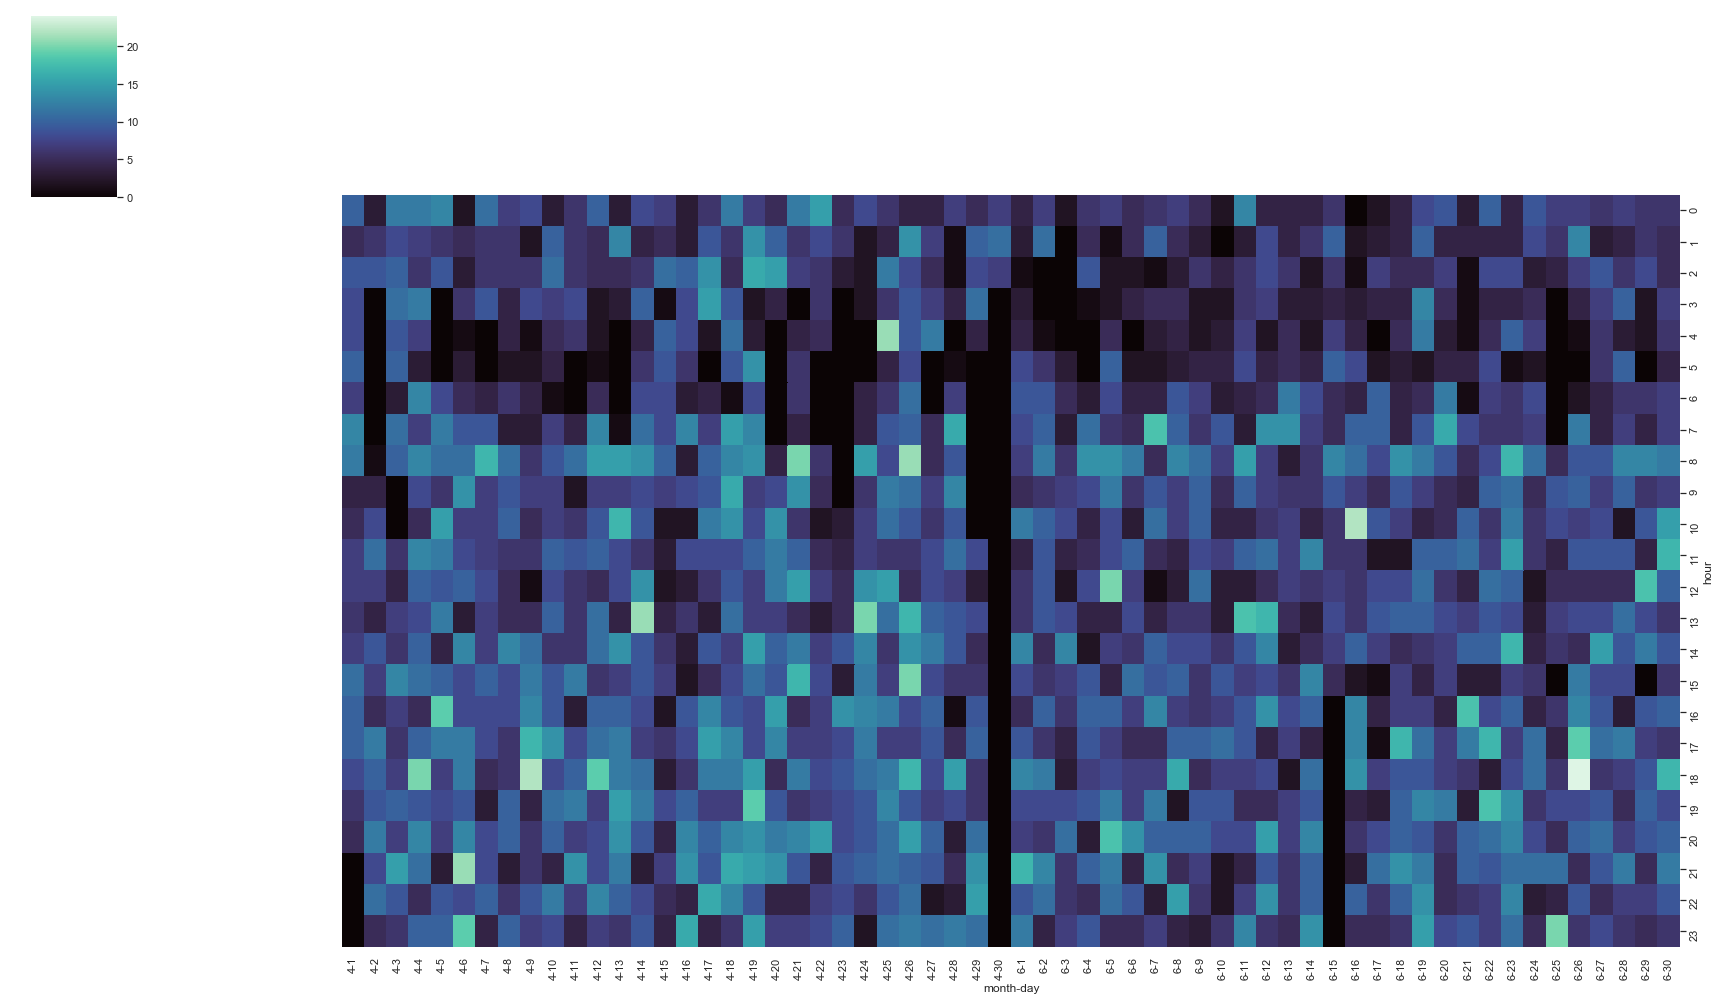

In [759]:
sns.clustermap(temp_data_staff, row_cluster=False, col_cluster=False, figsize=(24,14), cmap='mako')

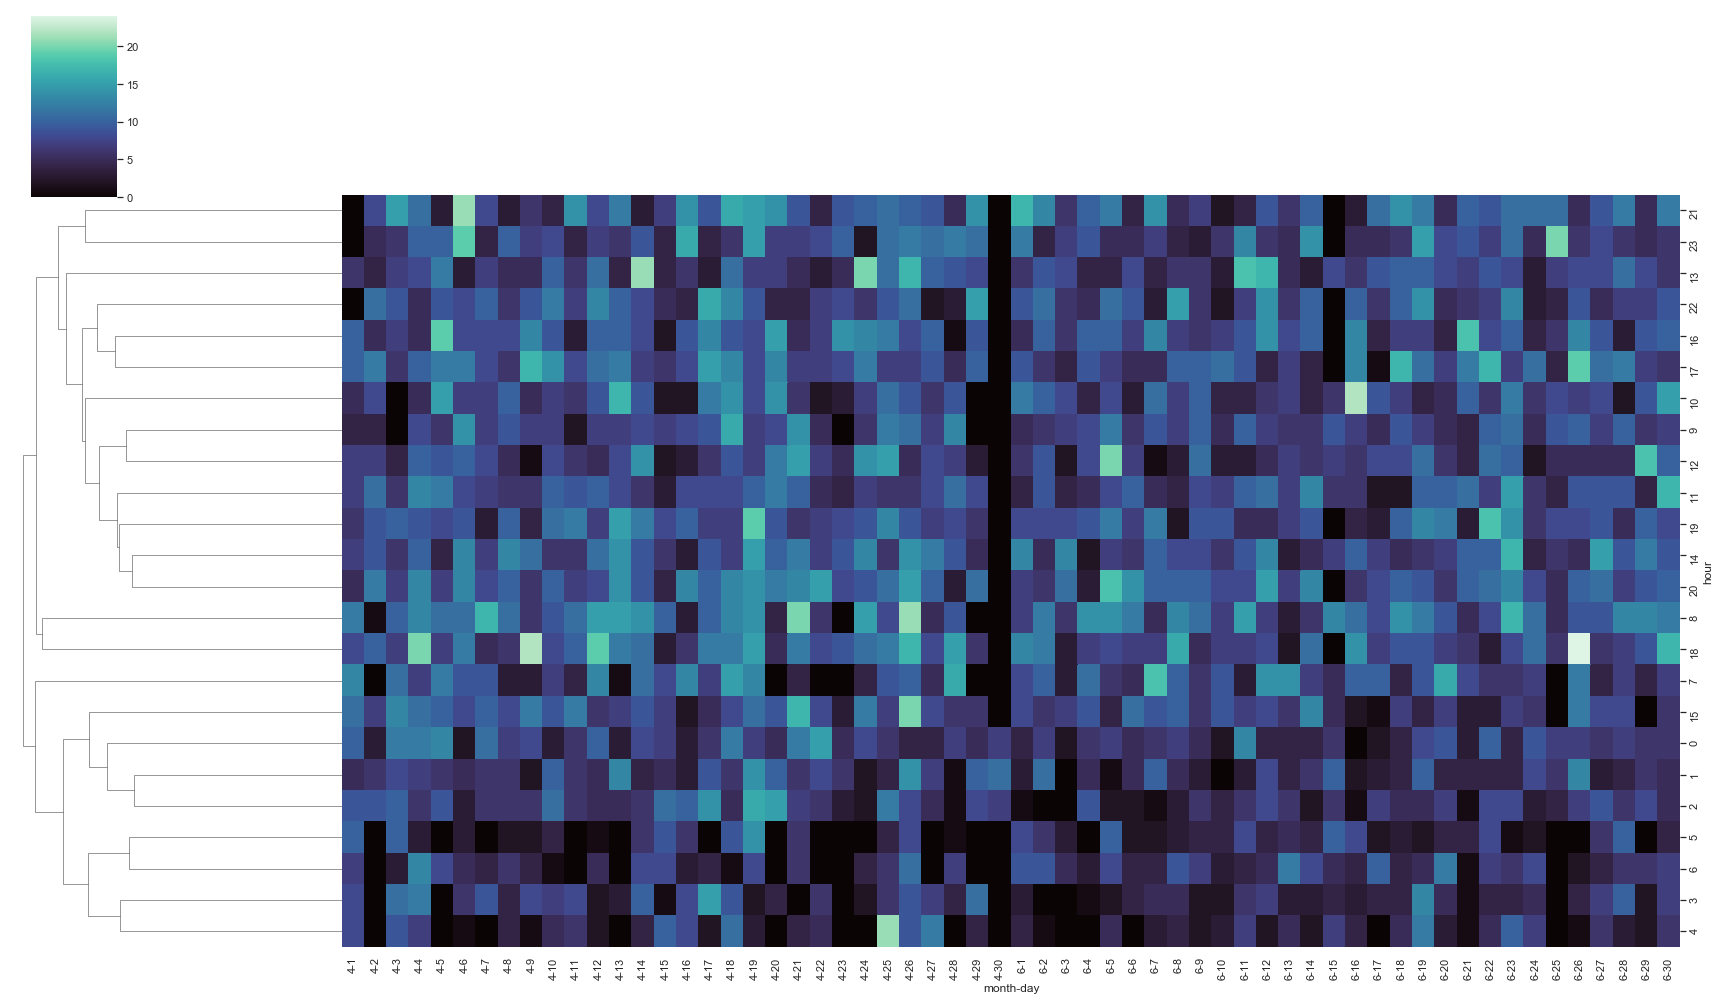

In [760]:
sns.clustermap(temp_data_staff, row_cluster=True, col_cluster=False, figsize=(24,14), cmap='mako')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15233c8d0>,
      dtype=object)

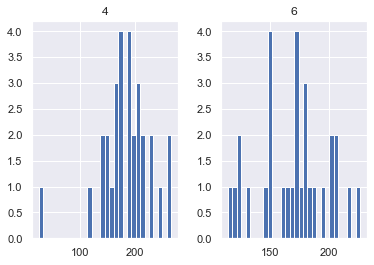

In [780]:
# Day of month hist
temp_data_staff.stack().sum(axis=0, level=1).hist(bins=30)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1528cfed0>,
      dtype=object)

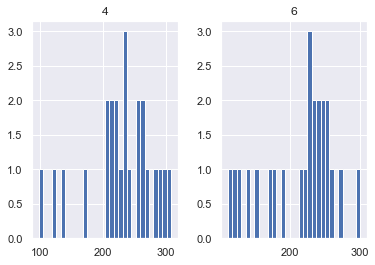

In [783]:
# Hour of day hist
temp_data_staff.sum(axis=1, level=0).hist(bins=30)

In [762]:
# All ED Staff
temp_data_all = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                  (supply_records_master['month'].isin([4,6]))].groupby(['month','day','hour']).count()[['event_id']].unstack().fillna(0)
temp_data_all = temp_data_all.transpose().droplevel(0)

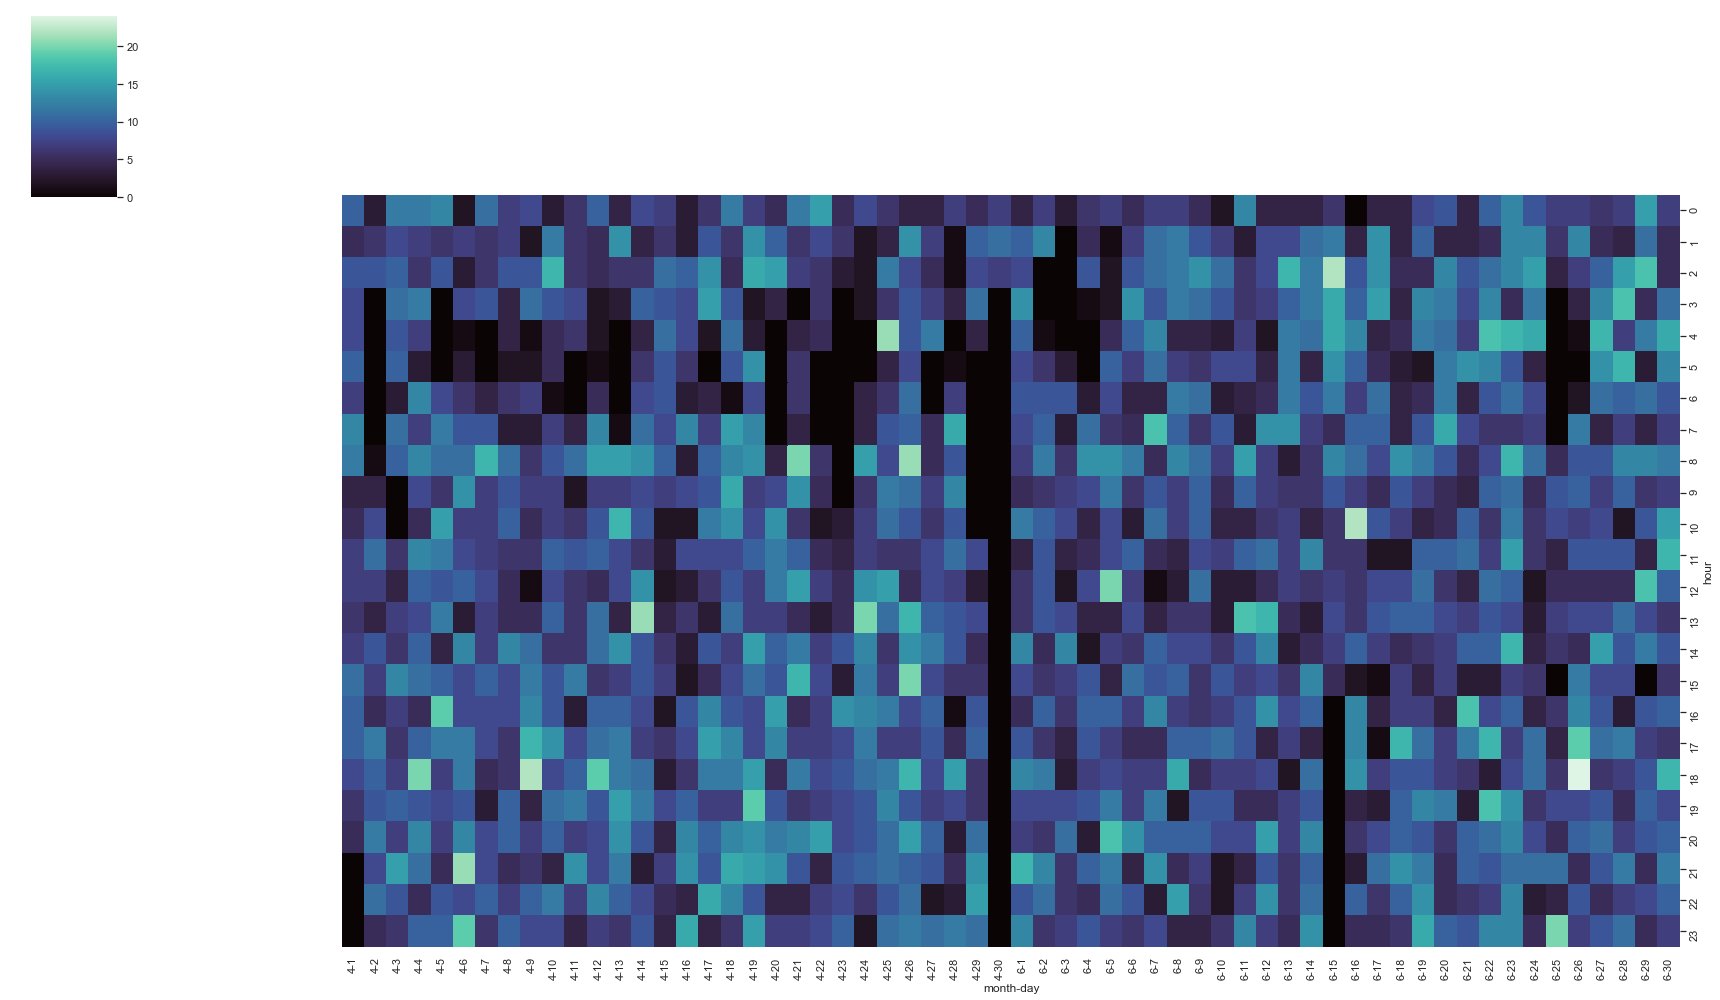

In [763]:
sns.clustermap(temp_data_all, row_cluster=False, col_cluster=False, figsize=(24,14), cmap='mako')

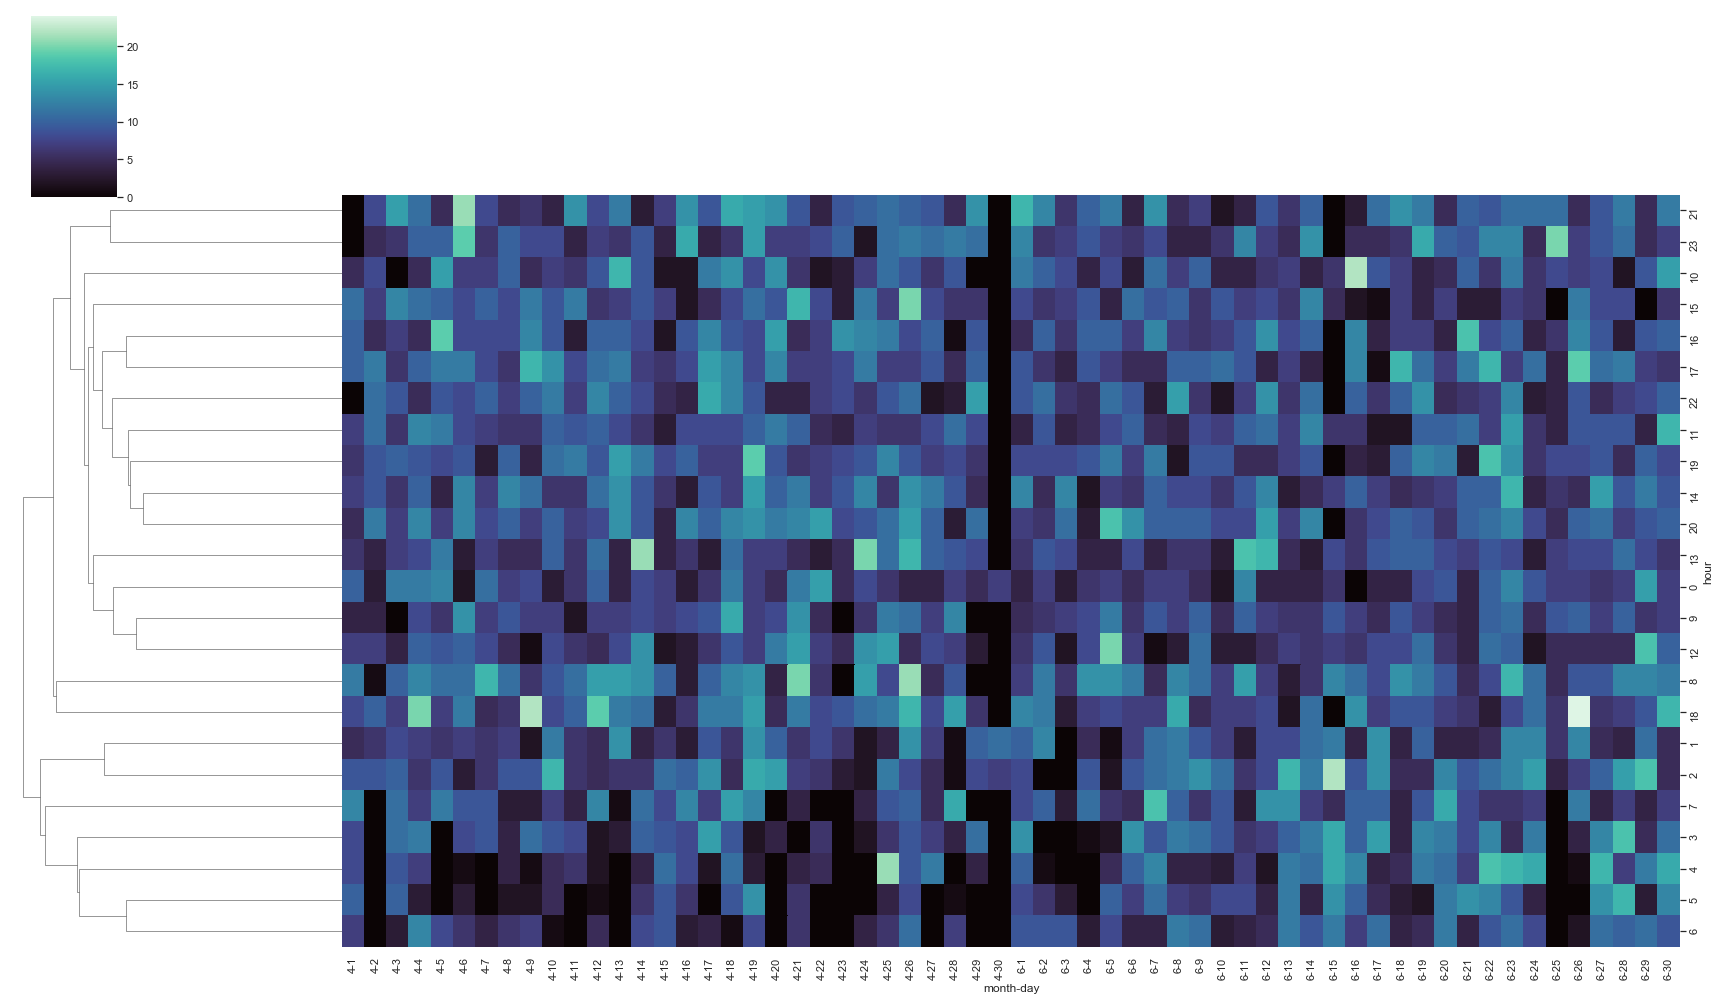

In [764]:
sns.clustermap(temp_data_all, row_cluster=True, col_cluster=False, figsize=(24,14), cmap='mako')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1524c7e10>,
      dtype=object)

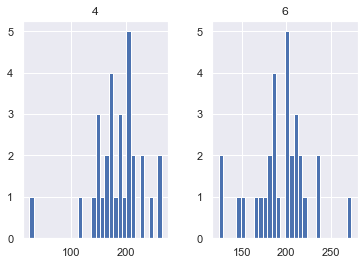

In [781]:
# Day of month hist
temp_data_all.stack().sum(axis=0, level=1).hist(bins=30)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15270a8d0>,
      dtype=object)

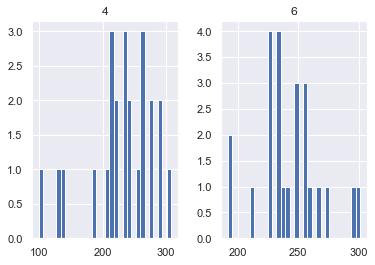

In [782]:
# Hour of day hist
temp_data_all.sum(axis=1, level=0).hist(bins=30)

In [752]:
supply_shifts = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                     (supply_records_master['month'].isin([4,6]))].groupby(['month','day','is_weekday','is_day_shift'])[['event_id']].count().unstack()
supply_shifts = supply_shifts.droplevel(axis=1,level=0)
supply_shifts = supply_shifts.reset_index().rename(columns={0:'night_shift',1:'day_shift'})
supply_shifts.head()

is_day_shift,month,day,is_weekday,night_shift,day_shift
0,4,1,0,68.0,100.0
1,4,2,0,63.0,78.0
2,4,3,1,110.0,77.0
3,4,4,1,108.0,120.0
4,4,5,1,75.0,129.0


In [753]:
card_data = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                     (supply_records_master['month'].isin([4,6]))].groupby(['month','day'])[['card_id']].nunique()
card_data = card_data.rename(columns={'card_id': 'Card Holders'})
card_data = card_data.reset_index()
card_data.head()

,month,day,Card Holders
0,4,1,59
1,4,2,51
2,4,3,67
3,4,4,72
4,4,5,76


In [754]:
supply_staff = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                     (supply_records_master['month'].isin([4,6]))].groupby(['month','day','is_weekday','is_day_shift','is_supply_staff'])[['event_id']].count().unstack([3,4]).fillna(0)
supply_staff = supply_staff.droplevel(axis=1,level=[0,1])
supply_staff = supply_staff.reset_index()
supply_staff = supply_staff.rename(columns={0:'ED Staff',1:'Supply Staff'}, level=0)
supply_staff.columns = ['Month', 'Day', 'Weekday', 'ED Staff Night', 'ED Staff Day', 'ED Supply Staff']
supply_staff['Month'] = supply_staff['Month'].map(month_dict)
supply_staff['Weekday'] = supply_staff['Weekday'].apply(lambda x: 'No' if x==0 else 'Yes')

supply_staff = pd.concat([supply_staff,card_data['Card Holders']], axis=1)

print(len(supply_staff))
supply_staff.head()

60


,Month,Day,Weekday,ED Staff Night,ED Staff Day,ED Supply Staff,Card Holders
0,Apr,1,No,68.0,100.0,0.0,59
1,Apr,2,No,63.0,78.0,0.0,51
2,Apr,3,Yes,110.0,77.0,0.0,67
3,Apr,4,Yes,108.0,120.0,0.0,72
4,Apr,5,Yes,73.0,129.0,2.0,76


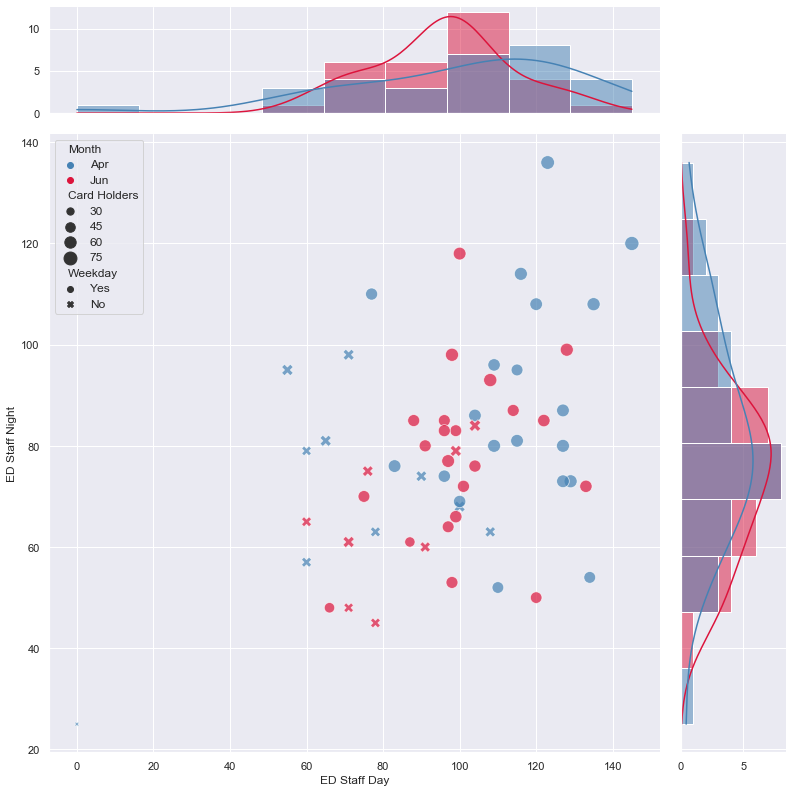

In [738]:
g = sns.JointGrid(data=supply_staff, x="ED Staff Day", y="ED Staff Night", hue="Month", marginal_ticks=True)
g.plot_joint(sns.scatterplot, style=supply_staff['Weekday'], style_order=['Yes','No'], size=supply_staff['Card Holders'], sizes=(20,200), palette = ['steelblue','crimson'], alpha=.7)
g.plot_marginals(sns.histplot, kde=True, palette = ['steelblue','crimson'])
g.fig.set_size_inches(12,12)

##### NOTE 2023/08/16:
* Differentiate by month and before/after vaughn

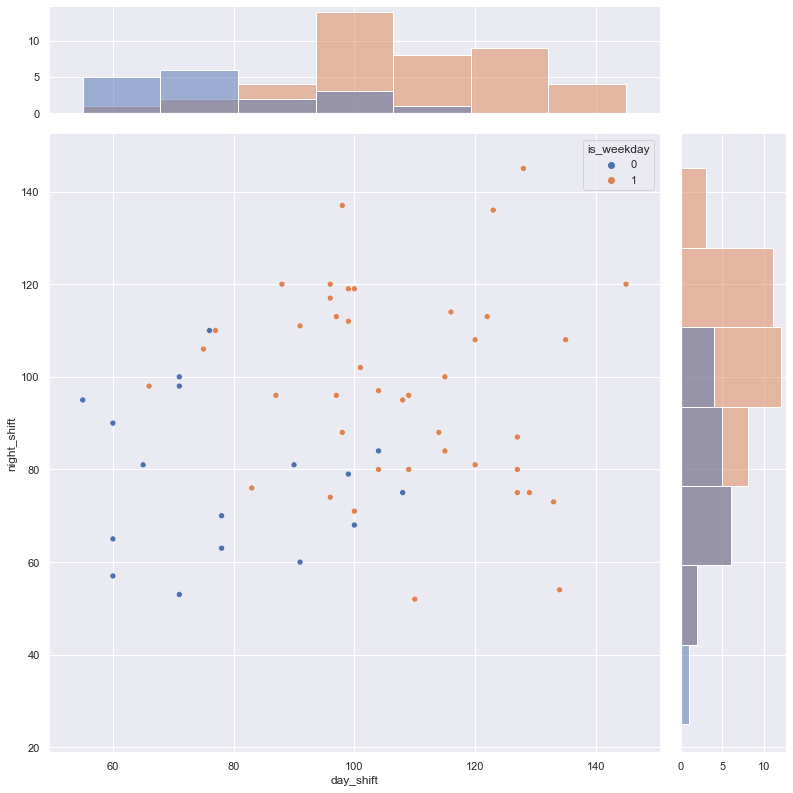

In [512]:
# I upgraded seaborn so this should work now, once I restart the kernel...
g = sns.JointGrid(data=supply_shifts, x="day_shift", y="night_shift", hue="is_weekday", marginal_ticks=True)
g.plot(sns.scatterplot, sns.histplot)
g.fig.set_size_inches(12,12)

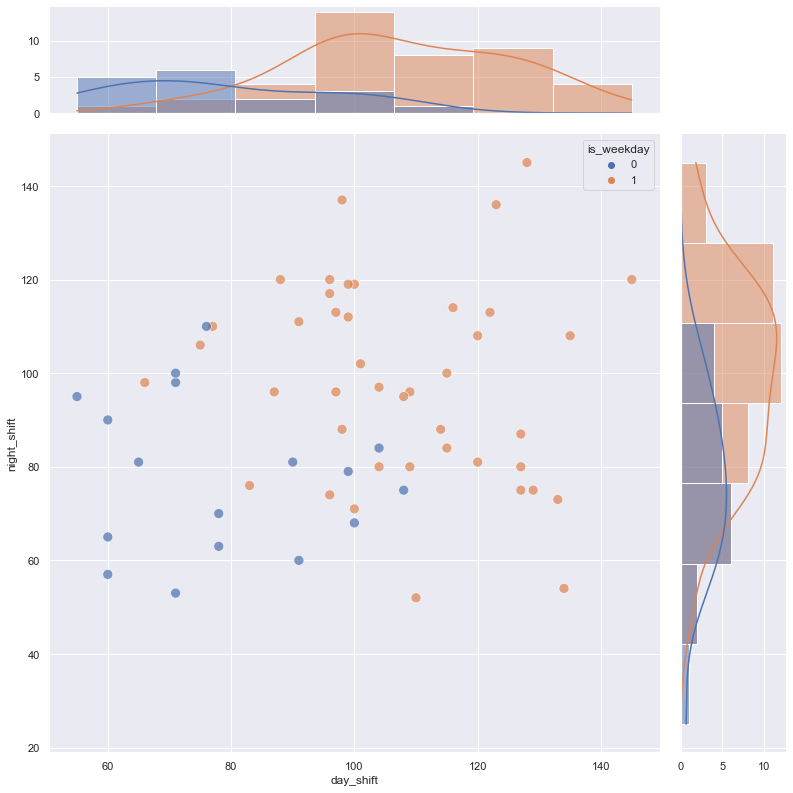

In [513]:
g = sns.JointGrid(data=supply_shifts, x="day_shift", y="night_shift", hue="is_weekday", marginal_ticks=True)
g.plot_joint(sns.scatterplot, s=100, alpha=.7)
g.plot_marginals(sns.histplot, kde=True)
g.fig.set_size_inches(12,12)

In [518]:
supply_shifts = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                     (supply_records_master['month'].isin([4,6]))].groupby(['month','day','dayofweek','is_day_shift'])[['event_id']].count().unstack()
supply_shifts = supply_shifts.droplevel(axis=1,level=0)
supply_shifts = supply_shifts.reset_index(level=-1).rename(columns={0:'night_shift',1:'day_shift'})
supply_shifts.head()

is_day_shift  dayofweek  night_shift  day_shift
month day                                      
4     1               5         68.0      100.0
      2               6         63.0       78.0
      3               0        110.0       77.0
      4               1        108.0      120.0
      5               2         75.0      129.0

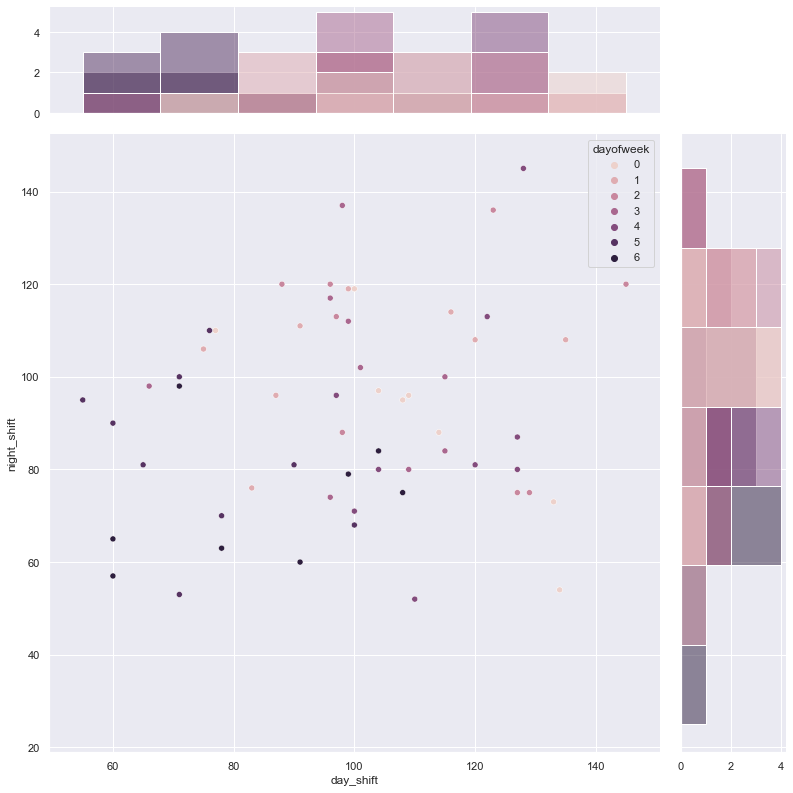

In [519]:
# I upgraded seaborn so this should work now, once I restart the kernel...
g = sns.JointGrid(data=supply_shifts, x="day_shift", y="night_shift", hue="dayofweek", marginal_ticks=True)
g.plot(sns.scatterplot, sns.histplot)
g.fig.set_size_inches(12,12)

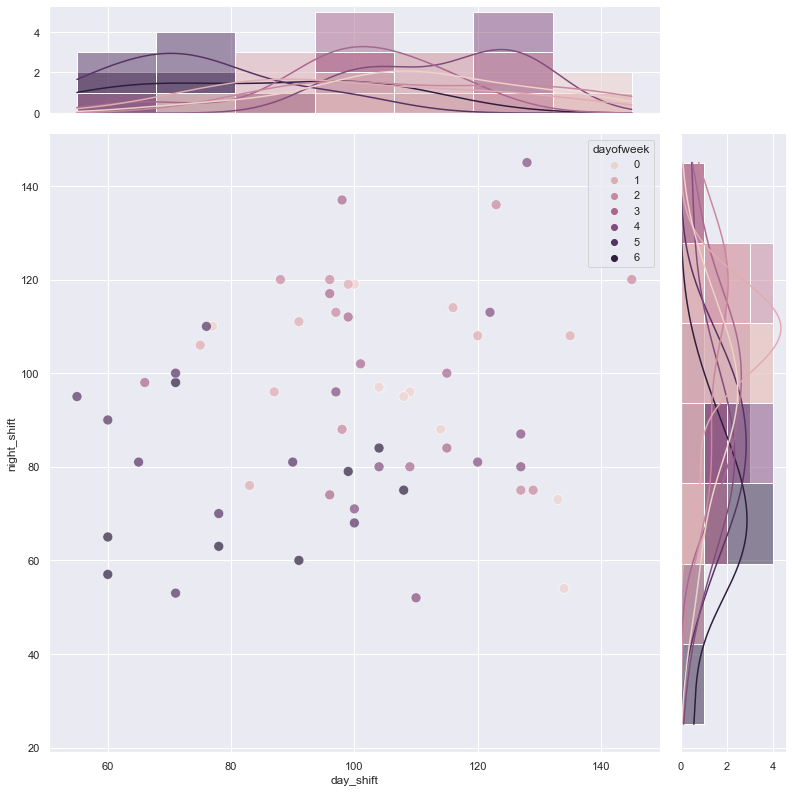

In [520]:
g = sns.JointGrid(data=supply_shifts, x="day_shift", y="night_shift", hue="dayofweek", marginal_ticks=True)
g.plot_joint(sns.scatterplot, s=100, alpha=.7)
g.plot_marginals(sns.histplot, kde=True)
g.fig.set_size_inches(12,12)

In [546]:
supply_cards = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                     (supply_records_master['month'].isin([4,6]))].groupby(['month','day','hour']).agg({'event_id':'count','card_id':'nunique'})
supply_cards = supply_cards.rename(columns={'event_id':'access_events','card_id':'card_holders'})
supply_cards = supply_cards.reset_index()
supply_cards.tail(100)

,month,day,hour,access_events,card_holders
1247,6,26,19,8,4
1248,6,26,20,10,7
1249,6,26,21,5,5
1250,6,26,22,9,8
1251,6,26,23,7,6
1252,6,27,0,6,5
1253,6,27,1,5,4
1254,6,27,2,10,8
1255,6,27,3,13,8
1256,6,27,4,17,6


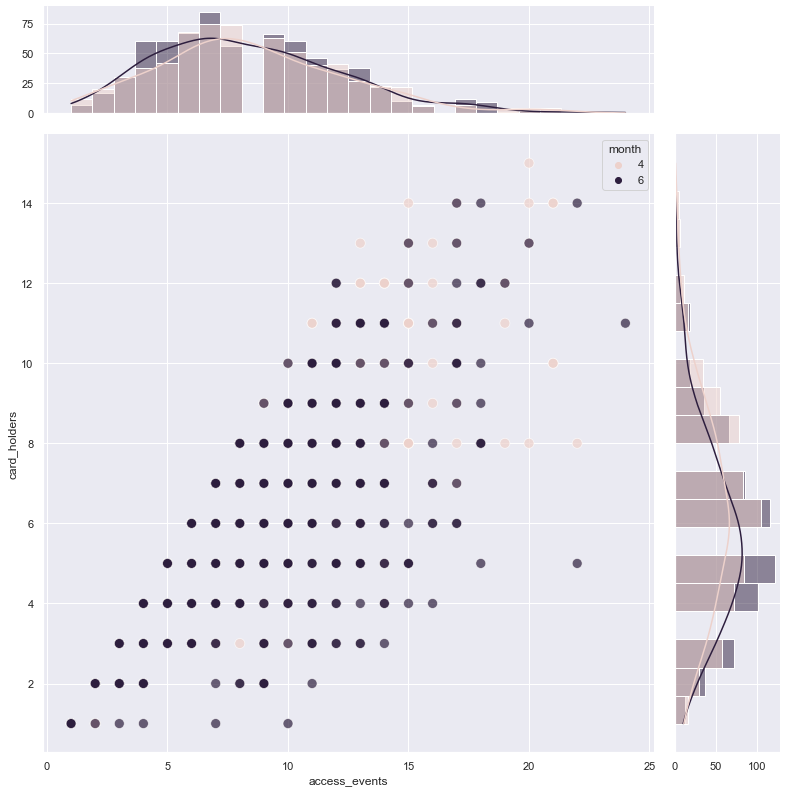

In [544]:
g = sns.JointGrid(data=supply_cards, x="access_events", y="card_holders", hue='month', marginal_ticks=True)
g.plot_joint(sns.scatterplot, s=100, alpha=.7)
g.plot_marginals(sns.histplot, kde=True)
g.fig.set_size_inches(12,12)

In [303]:
april_477244 = supply_records_master[(supply_records_master['supply_room_id']=='477244') & (supply_records_master['month']==4)]
may_477244 = supply_records_master[(supply_records_master['supply_room_id']=='477244') & (supply_records_master['month']==5)]
june_477244 = supply_records_master[(supply_records_master['supply_room_id']=='477244') & (supply_records_master['month']==6)]
april_477244_cards = april_477244.card_id.unique()
june_477244_cards = june_477244.card_id.unique()

april_477245 = supply_records_master[(supply_records_master['supply_room_id']=='477245') & (supply_records_master['month']==4)]
may_477245 = supply_records_master[(supply_records_master['supply_room_id']=='477245') & (supply_records_master['month']==5)]
june_477245 = supply_records_master[(supply_records_master['supply_room_id']=='477245') & (supply_records_master['month']==6)]
april_477245_cards = april_477245.card_id.unique()
june_477245_cards = june_477245.card_id.unique()

In [304]:
print('Access Events')
print('Closet 477244:')
print(len(april_477244))
print(len(june_477244))
print('Closet 477245:')
print(len(april_477245))
print(len(june_477245))

Access Events
Closet 477244:
4729
267
Closet 477245:
5518
5817


In [305]:
print('Card Id\'s')
print('Closet 477244:')
print(len(april_477244_cards))
print(len(june_477244_cards))
print('Closet 477245:')
print(len(april_477245_cards))
print(len(june_477245_cards))

Card Id's
Closet 477244:
426
51
Closet 477245:
428
397


In [306]:
temp_april_477244 = april_477244.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'april_477244'})
temp_april_477245 = april_477245.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'april_477245'})
temp_may_477244 = may_477244.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'may_477244'})
temp_may_477245 = may_477245.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'may_477245'})
temp_june_477244 = june_477244.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'june_477244'})
temp_june_477245 = june_477245.groupby('card_id')[['event_id']].count().sort_values(by='event_id', ascending=False).rename(columns={'event_id':'june_477245'})

In [ ]:
supply_records_master.head(2)

In [376]:
supply_ED_all = supply_records_master[(supply_records_master['supply_room_id']=='477245') & 
                                      (supply_records_master['month'].isin([4,6]))].groupby(['month','day'])[['event_id']].count().loc[[4,6],]
supply_ED_staff = supply_records_master[(supply_records_master['card_id']!=SUPPLY_STAFF_ID) & 
                                        (supply_records_master['supply_room_id']=='477245') & 
                                        (supply_records_master['month'].isin([4,6]))].groupby(['month','day'])[['event_id']].count().loc[[4,6],]
supply_ED_vaughn = supply_records_master[(supply_records_master['card_id']==SUPPLY_STAFF_ID) & 
                                         (supply_records_master['supply_room_id']=='477245') & 
                                         (supply_records_master['month'].isin([4,6]))].groupby(['month','day'])[['event_id']].count().loc[[4,6],]
supply_ED_merged = supply_ED_all.merge(supply_ED_staff, how='outer', left_index=True, right_index=True).merge(supply_ED_vaughn, how='outer', left_index=True, right_index=True).fillna(0)
supply_ED_merged = supply_ED_merged.rename(columns={'event_id_x':'All ED Staff','event_id_y':'ED Staff','event_id':'Supply Staff',})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136bcea90>,
      dtype=object)

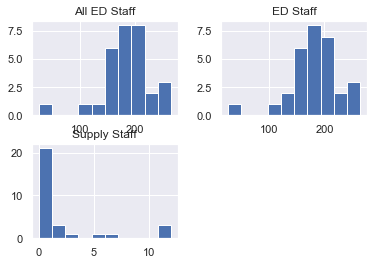

In [424]:
supply_ED_merged.loc[4].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d00f250>,
      dtype=object)

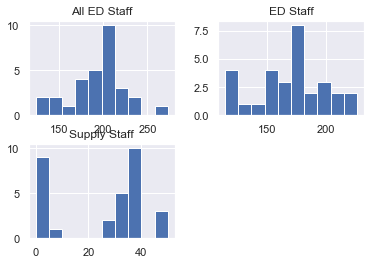

In [423]:
supply_ED_merged.loc[6].hist()

In [419]:
supply_ED_merged.loc[4].describe()

,All ED Staff,ED Staff,Supply Staff
count,30.0000,30.0000,30.0000
mean,183.9333,182.1000,1.8333
std,45.9902,46.1597,3.6207
min,25.0000,25.0000,0.0000
25%,163.5000,162.5000,0.0000
50%,187.5000,187.5000,0.0000
75%,206.5000,206.5000,2.0000
max,265.0000,265.0000,12.0000


In [418]:
supply_ED_merged.loc[6].describe()

,All ED Staff,ED Staff,Supply Staff
count,30.00,30.0000,30.0000
mean,193.90,169.6333,24.2667
std,31.48,29.5501,17.2125
min,124.00,114.0000,0.0000
25%,181.50,151.0000,2.5000
50%,201.50,173.0000,31.5000
75%,210.75,186.5000,36.0000
max,273.00,227.0000,50.0000


In [425]:
supply_ED_merged.sum(level=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



,All ED Staff,ED Staff,Supply Staff
month,,,
4,5518,5463,55.0
6,5817,5089,728.0


In [ ]:
stats.ttest_ind(supply_ED_merged.loc[4][['All ED Staff']], supply_ED_merged.loc[6][['ED Staff']], equal_var=False)

# Unused / Deprecated Code

In [ ]:
"""

# Create master supply room dataframe
supply_records = event_records.merge(response_records, how='inner', left_index=True, right_index=True)
supply_records['timestamp'] = pd.to_datetime(supply_records['timestamp'])
supply_records = supply_records.sort_values('timestamp')
supply_records = supply_records.reset_index(drop=True)

# Add event_id col for unique reference
event_id_col_loc = 0
event_id_col_name = 'event_id'
event_id_col_values = ['e'+str(idx).zfill(4) for idx in range(len(event_records))]

supply_records.insert(loc=event_id_col_loc, column=event_id_col_name, value=event_id_col_values)

"""

In [ ]:
"""

dayofweek_data_dict = dict()
dayofweek_data = supply_records_master.groupby(['year','month','day','dayofweek'])[['event_id']].count().unstack()
max_length = dayofweek_data.count().max()
min_length = dayofweek_data.count().min()
for col in dayofweek_data.columns:
    temp_series = dayofweek_data[col].dropna().to_list()
    if len(temp_series) < max_length:
        for i in range(max_length - len(temp_series)):
            temp_series.append(np.nan)
    dayofweek_data_dict[day_name_dict[col[1]]] = temp_series
    
dayofweek_df = pd.DataFrame(dayofweek_data_dict)

"""

In [ ]:
# Not sure if this was a duplicate graph
"""

fig, ax = plt.subplots(figsize=(18,12))
plt.grid(True)
width=0.3

room_477244_plot = data['477244'].plot(ax=ax, kind='bar', width=width, color='steelblue', ec='w', position=1)
room_477245_plot = data['477245'].plot(ax=ax, kind='bar', width=width, color='crimson', ec='w', position=0)

fig.suptitle('Supply Room Access by Day: Presby ED', fontsize=18, y=0.92)

ax.set_xlim(-1,len(data))
ax.set_xlabel('Date', fontsize=14)
ax.set_xticklabels(xlabels,rotation=0)

ax.set_ylabel('Access Events', fontsize=14)

"""

In [ ]:
"""

supply_records_master[(supply_records_master['supply_room_id']=='477244') & (supply_records_master['month']==6)].groupby(['card_holder'])[['event_id']].count().sort_values(ascending=False)

rooms = ['477244','477245']
numbers = ['1146','1135']
months = ['April','June']
col_levels = [(idx,num,mon) for idx,num,mon in zip(rooms,numbers,months)]
pd.MultiIndex.from_tuples(col_levels,names=['Room ID', 'Room Num', 'Month'])

"""

In [ ]:
# Old data validation code - might be useful to hold on to for future debugging/unseen faults
"""

supply_data[supply_data['card_holder']=='']
supply_data[supply_data['card_holder']=='']

temp1 = ' '.join(response_data.iloc[0:7]).split(' \'')

print(temp1[0])
print(temp1[1].split(']\' ')[0].split('[')[-1])
print(temp1[1].split(']\' ')[1].split()[1].split(')')[0])
try:
    print(temp1[1].split(']\' ')[1].split()[3].split(')')[0])
except:
    print('No facility id provided!')
    print(-999)
print(temp1[2].split(' [')[0])
print(temp1[2].split(' [')[-1].split(']')[0])

temp2 = ' '.join(response_data.iloc[12436:12443]).split(' \'')

print(temp2[0])
print(temp2[1].split(']\' ')[0].split('[')[-1])
print(temp2[1].split(']\' ')[1].split()[1].split(')')[0])
try:
    print(temp2[1].split(']\' ')[1].split()[3].split(')')[0])
except:
    print('No facility id provided!')
    print(-999)
print(temp2[2].split(' [')[0])
print(temp2[2].split(' [')[-1].split(']')[0])

temp3 = ' '.join(response_data.iloc[1547:1553]).split(' \'')

print(temp3[0])
print(temp3[1].split(']\' ')[0].split('[')[-1])
print(temp3[1].split(']\' ')[1].split()[1].split(')')[0])
try:
    print(temp3[1].split(']\' ')[1].split()[3].split(')')[0])
except:
    print('No facility id provided!')
    print(-999)
print(temp3[2].split(' [')[0])
print(temp3[2].split(' [')[-1].split(']')[0])


"""

In [ ]:
# Fun with numpy! learning learning learning everyday
"""

print(np.linspace((-2,-4),(2,4),5,axis=0))
print()
print(np.linspace((-2,-4),(2,4),5,axis=1))

a = np.arange(24).reshape((2,3,4))
b = np.arange(4)
c = np.inner(a, b)
d = np.inner(b, a)
e = np.outer(a, b)
f = np.outer(b, a)

print(a)
print()
print(b)

print(c.shape)
print(c)
print()
print(d.shape)
print(d)

print(e.shape)
print(e)
print()
print(f.shape)
print(f)

"""